In [182]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st


## Load firmware and configure data source

In [2]:
fpgfile="/home/ubuntu/kplant/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2021-10-04_1837.fpg"
brdname='snap01'
#load firmware and initialize etc
brd=snap2_fengine.Snap2Fengine(brdname)
brd.program(fpgfile)

casperbrd = casperfpga.CasperFpga(brdname, transport=casperfpga.TapcpTransport)

2021-10-06 19:28:52,946 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2021-10-06 19:28:53,258 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-10-06 19:28:53,601 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
2021-10-06 19:28:53,616 - lwa_f.snap2_fengine:snap01 - INFO - Loading firmware /home/ubuntu/kplant/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2021-10-04_1837.fpg to snap01
2021-10-06 19:29:18,864 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2021-10-06 19:29:19,195 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-10-06 19:29:19,552 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [3]:
setup_data_source(casperbrd,"adc")

Data source set to adc


# 1. Internally-Generated Whitenoise
## a. Setup whitenoise generator with brd.initialize()

In [4]:
brd.initialize()
brd.sync.arm_sync()
brd.sync.sw_sync()

2021-10-06 19:29:19,619 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): fpga
2021-10-06 19:29:19,620 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): adc
2021-10-06 19:29:19,621 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): sync
2021-10-06 19:29:19,621 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): noise
2021-10-06 19:29:19,622 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): input
2021-10-06 19:29:19,622 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): delay
2021-10-06 19:29:19,625 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): pfb
2021-10-06 19:29:19,626 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): eq
2021-10-06 19:29:19,627 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): eqtvg
2021-10-06 19:29:19,628 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (read only): reorder
2021-10

## b. Measure $F(v_{th})$ for various $v_{th}$.  

The threshold counters count for $2^{28}$ clock cycles and then update the SBRAM values. $2^{28}$ clock cycles is about 1.36 seconds for a 197 MHz clock rate. After updating a threshold, I need to wait 2x1.36 = 2.73 seconds before reading, in order to be certain that the new threshold was in place for the entire time represented by the count currently in the SBRAM.

$2^{28}$ clock cycles is long enough for a 5.89595 sigma event. Specifically, what I mean is Probability(x>5.89595)=1/(2^28).  Not the same as expectation value. See Mathematica notebook.  I will have the threshold scan go to 6 sigma.

I set core threshold and veto thresholds independentantly, and there are separate counters counting how many times each antenna exceeds the core threshold and how many times it exceeds the veto threshold.  Thus, I can measure $F(v_{th})$ for two different values of $v_{th}$ in each set of $2^{28}$ clock cycles.  In the threshold scans that follow, the core threshold steps through the set of test thresholds in increasing order, and the veto threshold steps through in decreasing order.  Thus, each scan makes a measurement with the same threshold twice, i.e. on two different $2^{28}$-clock-cycle samples.   

Antenna roles have not been applied at this stage, so "core" and "veto" just refer to the two different simultaneous measurements.

In [53]:
#calculate counter time
print((2**28)*(5e-9))
print((2**28)*(1/1.97e8))
print(1.3626165279187816*2)

1.34217728
1.3626165279187816
2.7252330558375633


In [54]:
thresholds = np.logspace (0,np.log10(6*16),100)
results_core = np.zeros((64,100))
results_veto = np.zeros((64,100))

for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = thresholds[99-i]
    setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
    setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
    time.sleep(2.75)  #have to wait for it to update
    core,veto = read_threshold_rates(casperbrd)
    results_core[:,i] = core
    results_veto[:,i] = veto

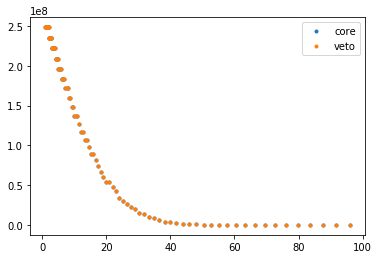

In [7]:
plt.plot(thresholds,results_core[1,:],'.',label='core')
plt.plot(np.flip(thresholds),results_veto[1,:],'.',label='veto')
plt.legend()

I've made the thresholds more closely spaced than quantization levels, which doesn't make sense to do, so I do it again below with only integers as thresholds. Before, maximum threshold was 96, so I may as well do integers 0 to 99.

In [8]:
thresholds = np.linspace (0,99,100)
vthresholds = np.flip(thresholds)
results_core = np.zeros((64,100))
results_veto = np.zeros((64,100))

for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = vthresholds[i]
    setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
    setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
    time.sleep(2.75)  #have to wait for it to update
    core,veto = read_threshold_rates(casperbrd)
    results_core[:,i] = core
    results_veto[:,i] = veto

Text(0.5, 0, 'Threshold')

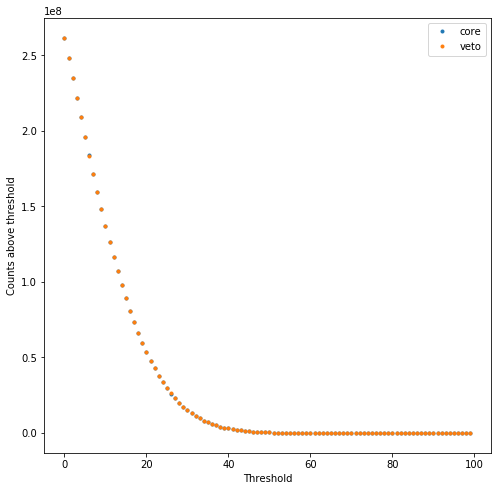

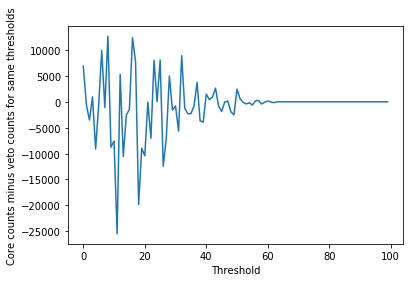

In [52]:

plt.figure(figsize=(8,8))
plt.plot(thresholds,results_core[1,:],'.',label='core')
plt.plot(np.flip(thresholds),results_veto[1,:],'.',label='veto')
plt.ylabel("Counts above threshold")
plt.xlabel("Threshold")
plt.legend()

plt.figure()
plt.plot(results_core[1,:]-np.flip(results_veto[1,:]))
plt.ylabel("Core counts minus veto counts for same thresholds")
plt.xlabel("Threshold")


In [10]:
#save the arrays
np.save("internalwhitenoise_thresholds_core",thresholds)
np.save("internalwhitenoise_thresholds_veto",vthresholds)
np.save("internalwhitenoise_results_core",results_core)
np.save("internalwhitenoise_results_veto",results_veto)


## c. Fit Models to data 
With and without zero mean assumption

In [70]:
def prob(x,m,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with mean m and variance s^2
    p = 1 - 0.5*(sp.erf((x + m)/((2**0.5)*s)) + sp.erf((x - m)/((2**0.5)*s)))
    return p

def prob_simple(x,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with zero mean and variance s^2
    p = 1 - 0.5*(sp.erf((x)/((2**0.5)*s)) + sp.erf((x)/((2**0.5)*s)))
    return p

In [188]:
thresholds=np.load("internalwhitenoise_thresholds_core.npy")
vthresholds=np.load("internalwhitenoise_thresholds_veto.npy")
results_core=np.load("internalwhitenoise_results_core.npy")
results_veto=np.load("internalwhitenoise_results_veto.npy")

The default standard deviation of the internally generated noise isn't known, but snapshot estimates suggested that it's probably 16.  Below, I plot the threshold scan results, converted to fraction of the sample, compared to the a model for a Gaussian distribution with zero mean and standard deviation 16.  This model is very very close to the data but consistently overestimates. 

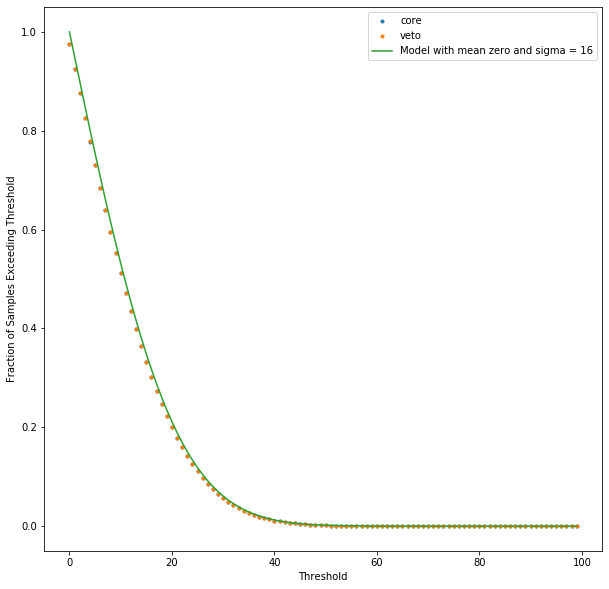

In [189]:
rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)
model = prob_simple(thresholds,16)
#modeltest = prob(thresholds,0,16)

plt.figure(figsize=(10,10))
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.plot(thresholds,rate_core[1,:],'.',label='core')
plt.plot(vthresholds,rate_veto[1,:],'.',label='veto')

plt.plot(thresholds,model,label='Model with mean zero and sigma = 16')
#plt.plot(thresholds,modeltest,label='Model with mean zero and sigma = 16, using function prob')

plt.legend()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


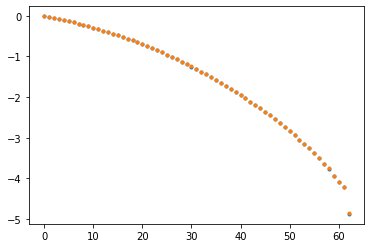

In [190]:
plt.figure()
plt.plot(thresholds,np.log10(rate_core[1,:]),'.',label='core')
plt.plot(vthresholds,np.log10(rate_veto[1,:]),'.',label='veto')
#plt.plot(thresholds,np.log10(model),'.',label='veto')


Note that the first value is not expected to be 1 because whenever the voltage is zero no threshold can be exceeded (minimum threshold is zero).

In [191]:
print("Fit 1")
popt,pcov = oz.curve_fit(prob_simple,thresholds,rate_core[1,:])
print(popt)
print(pcov)

print("Fit 2")
popt2,pcov2 = oz.curve_fit(prob,thresholds,rate_core[1,:])
print(popt2)
print(pcov2)

print("Fit 3")
p0=(0,16)
popt3,pcov3 = oz.curve_fit(prob,thresholds,rate_core[1,:],p0)
print(popt3)
print(pcov3)

print("Fit 4")
p0=(0,15.42)
popt4,pcov4 = oz.curve_fit(prob,thresholds,rate_core[1,:],p0)
print(popt4)
print(pcov4)

print("Fit 5")
p0=(0,1)
popt5,pcov5 = oz.curve_fit(prob,thresholds,rate_core[1,:],p0)
print(popt5)
print(pcov5)

Fit 1
[15.42933891]
[[0.0019102]]
Fit 2
[-0.12385342 15.42885035]
[[3.51165286e+08 2.81905782e+06]
 [2.81905782e+06 2.26306186e+04]]
Fit 3
[ 0. 16.]
[[ 5.86458140e+10 -3.54085503e+03]
 [-3.54085503e+03  5.53940894e-03]]
Fit 4
[ 0.   15.42]
[[1.77241208e+10 3.45641493e+02]
 [3.45641493e+02 1.93613995e-03]]
Fit 5
[ 0.04411576 15.42927783]
[[ 4.37726342e+07 -1.25115634e+05]
 [-1.25115634e+05  3.57620840e+02]]


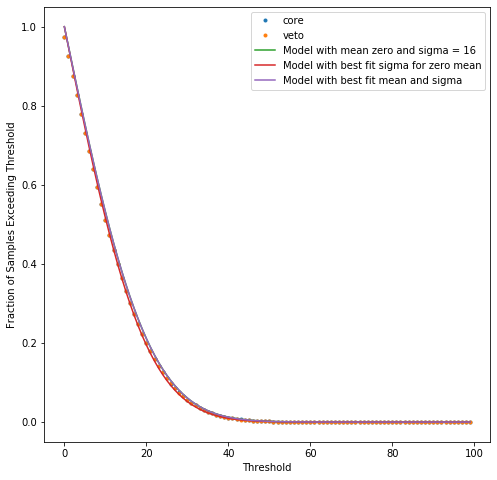

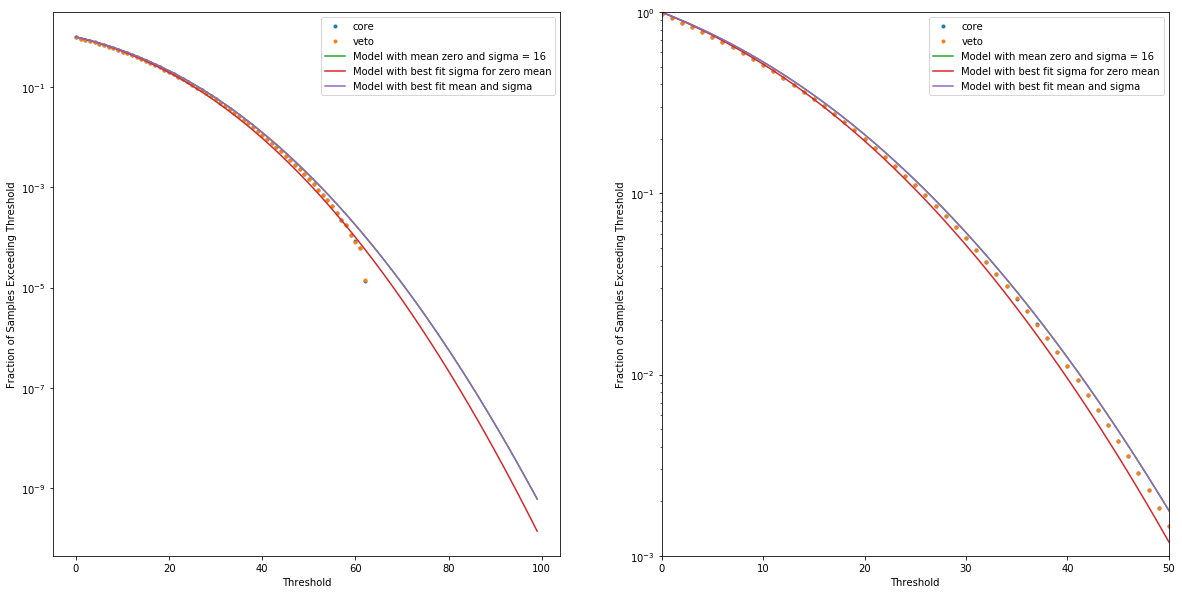

In [192]:

model1 = prob_simple(thresholds,16)
model2 = prob_simple(thresholds,popt[0])
model3 = prob(thresholds,popt3[0],popt3[1])
model4 = prob(thresholds,popt4[0],popt4[1])
model5 = prob(thresholds,popt5[0],popt5[1])

plt.figure(figsize=(8,8))
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
#plt.subplot(131)
plt.plot(thresholds,rate_core[1,:],'.',label='core')
plt.plot(vthresholds,rate_veto[1,:],'.',label='veto')

plt.plot(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.plot(thresholds,model2,label='Model with best fit sigma for zero mean')
plt.plot(thresholds,model3,label='Model with best fit mean and sigma')
plt.legend()

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.semilogy(thresholds,rate_core[1,:],'.',label='core')
plt.semilogy(vthresholds,rate_veto[1,:],'.',label='veto')

plt.semilogy(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.semilogy(thresholds,model2,label='Model with best fit sigma for zero mean')
plt.semilogy(thresholds,model3,label='Model with best fit mean and sigma')
#plt.semilogy(thresholds,model4,label='Model 4')
#plt.semilogy(thresholds,model5,label='Model 5')
plt.legend()

plt.subplot(122)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.semilogy(thresholds,rate_core[1,:],'.',label='core')
plt.semilogy(vthresholds,rate_veto[1,:],'.',label='veto')

plt.semilogy(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.semilogy(thresholds,model2,label='Model with best fit sigma for zero mean')
plt.semilogy(thresholds,model3,label='Model with best fit mean and sigma')
#plt.semilogy(thresholds,model4,label='Model 4')
#plt.semilogy(thresholds,model5,label='Model 5')
plt.xlim(0,50)
plt.ylim(0.001,1)
plt.legend()

Mean and sigma are strongly covariant.  Chi  square calculation below is wrong because I don't include uncertainties.

### Try again with error bars
See paper notebook page 29
I only use data points 5 to 50 in the fit, to stay in the range where the binomial error bars approach Gaussian. (This is an estimate, I didn't calculate exactly where the cuttoff should be).  It didn't really improve the fit.

In [229]:
#calculate square root of the variance of the number of times a threshold will be exceeded, which follows a binomial distribution
#don't forget to later divide by n if plotting on axes from zero to one instead of number of counts
def binomial_error(p,n):
    variance = n*p*(1-p)
    return np.sqrt(variance)

In [233]:
#model fit including error
print("Fit 1")
p0=16
sigma=2**-28*binomial_error(rate_core[1,5:55],2**28)
popt1,pcov1 = oz.curve_fit(prob_simple,thresholds[5:55],rate_core[1,5:55],p0,sigma)
print(popt1)
print(pcov1)

print("Fit 2")
sigma=2**-28*binomial_error(rate_core[1,5:55],2**28)
p0=(0,16)
popt2,pcov2 = oz.curve_fit(prob,thresholds[5:55],rate_core[1,5:55],p0,sigma)
print(popt2)
print(pcov2)

model1 = prob_simple(thresholds,16)
model2 = prob(thresholds,popt2[0],popt2[1])

Fit 1
[15.59103111]
[[0.00104218]]
Fit 2
[ 0. 16.]
[[ 2.94700020e+09 -4.64497474e+02]
 [-4.64497474e+02  4.38395736e-03]]


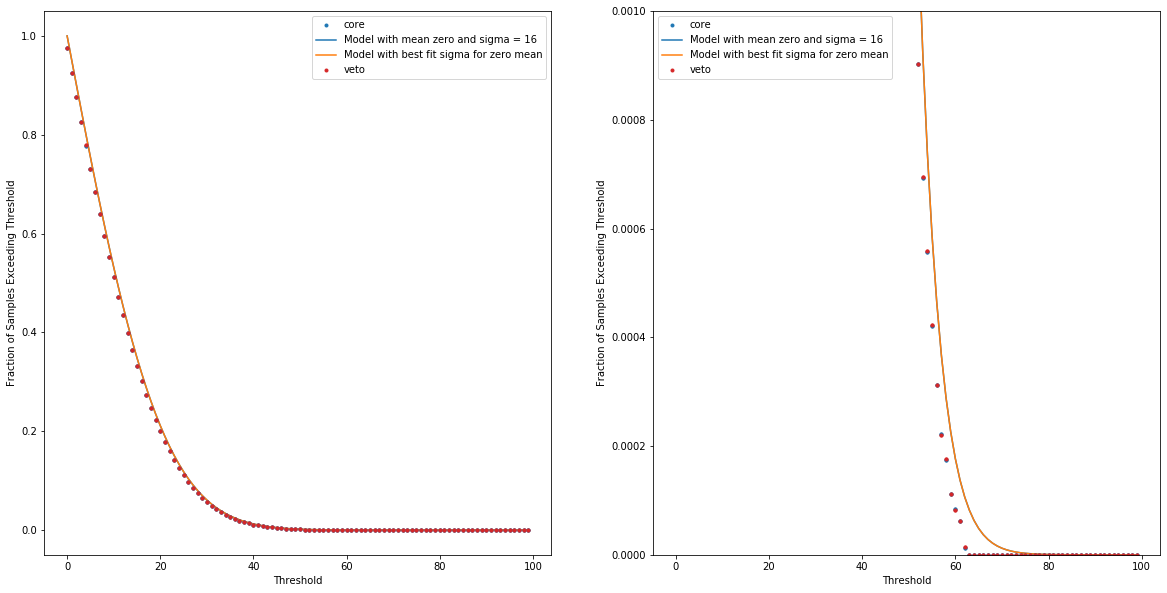

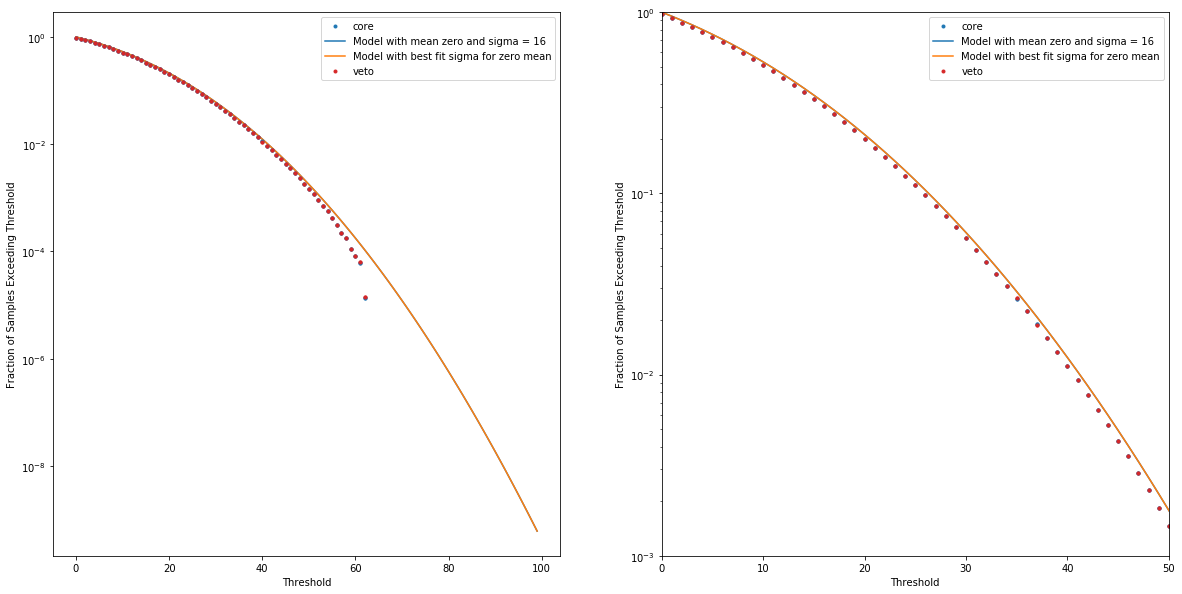

In [234]:

plt.figure(figsize=(20,10))
plt.subplot(121)

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.plot(thresholds,rate_core[1,:],'C0.',label='core')
plt.errorbar(thresholds,rate_core[1,:],(2**-28)*binomial_error(rate_core[1,:],2**28),color='C0',marker='.',linestyle='none')
plt.plot(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.plot(thresholds,model2,label='Model with best fit sigma for zero mean')

plt.plot(vthresholds,rate_veto[1,:],'C3.',label='veto')
plt.errorbar(vthresholds,rate_veto[1,:],(2**-28)*binomial_error(rate_veto[1,:],2**28),color='C3',marker='.',linestyle='none')
plt.legend()

plt.subplot(122)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.plot(thresholds,rate_core[1,:],'C0.',label='core')
plt.errorbar(thresholds,rate_core[1,:],(2**-28)*binomial_error(rate_core[1,:],2**28),color='C0',marker='.',linestyle='none')
plt.plot(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.plot(thresholds,model2,label='Model with best fit sigma for zero mean')

plt.plot(vthresholds,rate_veto[1,:],'C3.',label='veto')
plt.errorbar(vthresholds,rate_veto[1,:],(2**-28)*binomial_error(rate_veto[1,:],2**28),color='C3',marker='.',linestyle='none')
plt.ylim(0,0.001)
plt.legend()

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.semilogy(thresholds,rate_core[1,:],'C0.',label='core')
plt.errorbar(thresholds,rate_core[1,:],(2**-28)*binomial_error(rate_core[1,:],2**28),color='C0',marker='.',linestyle='none')
plt.semilogy(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.semilogy(thresholds,model2,label='Model with best fit sigma for zero mean')
plt.semilogy(vthresholds,rate_veto[1,:],'C3.',label='veto')
plt.errorbar(vthresholds,rate_veto[1,:],(2**-28)*binomial_error(rate_veto[1,:],2**28),color='C3',marker='.',linestyle='none')
plt.legend()

plt.subplot(122)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")

plt.semilogy(thresholds,rate_core[1,:],'C0.',label='core')
plt.errorbar(thresholds,rate_core[1,:],(2**-28)*binomial_error(rate_core[1,:],2**28),color='C0',marker='.',linestyle='none')
plt.semilogy(thresholds,model1,label='Model with mean zero and sigma = 16')
plt.semilogy(thresholds,model2,label='Model with best fit sigma for zero mean')
plt.semilogy(vthresholds,rate_veto[1,:],'C3.',label='veto')
plt.errorbar(vthresholds,rate_veto[1,:],(2**-28)*binomial_error(rate_veto[1,:],2**28),color='C3',marker='.',linestyle='none')
plt.legend()

plt.xlim(0,50)
plt.ylim(0.001,1)
plt.legend()

The error bars are too small to see, so I compare the error bars to the difference between core and veto, and it looks like the error bars are a reasonable estimate.

Text(0.5, 0, 'Threshold')

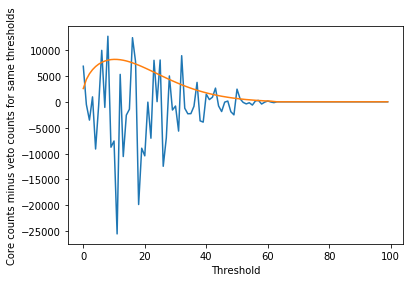

In [225]:
plt.figure()
plt.plot(results_core[1,:]-np.flip(results_veto[1,:]),label="Core - veto")
plt.plot(binomial_error(rate_core[1,:],2**28),label="Estimate of uncertainty")
plt.ylabel("Core counts minus veto counts for same thresholds")
plt.xlabel("Threshold")

In [116]:
def chisquare(model,data):
    chisq = np.sum(np.square(model - data)/model)
    return chisq/len(model-1)


In [117]:
print("Model 1")
print(chisquare(model1,rate_core[1,:]))
print("Model 2")
print(chisquare(model2,rate_core[1,:]))
print("Model 3")
print(chisquare(model3,rate_core[1,:]))
print("Model 4")
print(chisquare(model4,rate_core[1,:]))
print("Model 5")
print(chisquare(model5,rate_core[1,:]))

print("Model 1, first part only")
print(chisquare(model1[:50],rate_core[1,:50]))


Model 1
0.00023478911114902984
Model 2
0.00012607526822695073
Model 3
0.00023478911114902984
Model 4
0.00013158062221356874
Model 5
0.0001260741209441548
Model 1, first part only
0.00044888713110221266


# 2. Sky Signal
## a. Change data source from internally generated noise to ADC samples

In [16]:
brd.initialize(read_only=False)
brd.sync.arm_sync()
brd.sync.sw_sync()

2021-10-06 20:32:07,257 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (writable): fpga
2021-10-06 20:32:07,259 - lwa_f.snap2_fengine:snap01 - INFO - Initializing block (writable): adc
2021-10-06 20:32:07,265 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0: Setting clock source to 1
2021-10-06 20:32:07,273 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 1: Setting clock source to 1
2021-10-06 20:32:07,280 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 board 0: Setting clock source to 1
2021-10-06 20:32:07,288 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 board 1: Setting clock source to 1
2021-10-06 20:32:16,945 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0 clock rates: [490649522, 98173099, 98212130, 0, 0]
2021-10-06 20:32:16,946 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 0: MMCM locked
2021-10-06 20:32:17,957 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 board 1 clock rates: [490668650, 98185877, 98239082, 98288068, 0]
2021-10-

2021-10-06 20:32:29,632 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 because delay end too small
2021-10-06 20:32:29,635 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 1 because delay end too small


2021-10-06 20:32:30,864 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 Scanning data delays


2021-10-06 20:32:39,339 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane delays:
[[192, 184, 192, 176, 184, 176, 176, 168], [176, 168, 160, 160, 168, 168, 160, 160], [152, 152, 152, 160, 152, 152, 152, 168], [176, 184, 160, 168, 168, 160, 168, 160], [152, 152, 152, 160, 160, 160, 152, 160], [152, 152, 168, 152, 144, 152, 144, 144], [184, 168, 168, 168, 168, 176, 168, 168], [232, 224, 224, 224, 216, 232, 240, 216]]
2021-10-06 20:32:39,340 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 32, 32, 32], [32, 32, 32, 40, 40, 40, 40, 32], [40, 40, 40, 40, 40, 32, 32, 32], [40, 32, 32, 40, 32, 32, 40, 32], [40, 40, 40, 32, 32, 32, 40, 32], [40, 40, 40, 40, 32, 40, 40, 32], [40, 40, 40, 32, 32, 32, 40, 40], [40, 32, 32, 40, 40, 40, 40, 40]]
2021-10-06 20:32:39,340 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,341 - lwa_f.blocks.block:snap01 - INF

2021-10-06 20:32:39,365 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 4, Lane 4:    XXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,365 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 4, Lane 5:    XXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,366 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 4, Lane 6:    XXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,367 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 4, Lane 7:    XXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,368 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 5, Lane 0:    XXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,368 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 5, Lane 1:    XXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:39,369 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 5, Lane 2:    XXXXXXXX

2021-10-06 20:32:51,365 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane delays:
[[296, 304, 304, 304, 296, 296, 288, 304], [288, 288, 288, 288, 288, 296, 288, 280], [288, 288, 288, 304, 288, 296, 296, 280], [328, 344, 328, 336, 328, 336, 328, 328], [280, 280, 280, 288, 280, 280, 280, 280], [328, 320, 320, 320, 328, 320, 328, 328], [288, 272, 280, 296, 280, 280, 280, 288], [272, 280, 280, 272, 272, 272, 272, 272]]
2021-10-06 20:32:51,366 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane slacks:
[[40, 48, 48, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 48, 40, 40, 40, 40], [48, 40, 48, 40, 40, 40, 40, 40], [40, 32, 32, 32, 40, 32, 40, 40], [40, 32, 32, 40, 32, 40, 40, 40], [40, 40, 40, 48, 40, 40, 40, 40]]
2021-10-06 20:32:51,367 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,367 - lwa_f.blocks.block:snap01 - INF

2021-10-06 20:32:51,403 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,404 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,405 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,405 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,406 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXX


2021-10-06 20:32:51,407 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,407 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,408 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 1:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,409 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,409 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX-----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,410 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2021-10-06 20:32:51,411 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 5:    XXXXXXXX

## b. Measure $F(v_{th})$ for various $v_{th}$.  

Now, I expect the rms to be about ~50 so 6 sigma is 300.  I'll use every third integer as a threshold, up to 297.

In [236]:
thresholds = 3*np.asarray(range(100))

In [237]:
thresholds = 3*np.asarray(range(100))
vthresholds = np.flip(thresholds)
results_core = np.zeros((64,100))
results_veto = np.zeros((64,100))

for i in range(len(thresholds)):
    t_c = thresholds[i]
    t_v = vthresholds[i]
    setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(t_c**2))
    setvalue(casperbrd,"veto_power_thresh","cr_registers.xlsx",int(t_v**2))
    time.sleep(2.75)  #have to wait for it to update
    core,veto = read_threshold_rates(casperbrd)
    results_core[:,i] = core
    results_veto[:,i] = veto

KeyboardInterrupt: 

In [247]:
'''
plt.figure(figsize=(10,10))
plt.plot(thresholds,results_core[1,:],'.',label='core')
plt.plot(np.flip(thresholds),results_veto[1,:],'.',label='veto')
plt.legend()

plt.figure()
plt.plot(results_core[1,:]-np.flip(results_veto[1,:]))

plt.figure()
plt.plot(thresholds,np.log10(results_core[1,:]),'.',label='core')
plt.plot(np.flip(thresholds),np.log10(results_veto[1,:]),'.',label='veto')
plt.legend()
'''

"\nplt.figure(figsize=(10,10))\nplt.plot(thresholds,results_core[1,:],'.',label='core')\nplt.plot(np.flip(thresholds),results_veto[1,:],'.',label='veto')\nplt.legend()\n\nplt.figure()\nplt.plot(results_core[1,:]-np.flip(results_veto[1,:]))\n\nplt.figure()\nplt.plot(thresholds,np.log10(results_core[1,:]),'.',label='core')\nplt.plot(np.flip(thresholds),np.log10(results_veto[1,:]),'.',label='veto')\nplt.legend()\n"

In [31]:
#n=2
#save the arrays
#np.save("sky_thresholds_core"+str(n),thresholds)
#np.save("sky_thresholds_veto"+str(n),vthresholds)
#np.save("sky_results_core"+str(n),results_core)
#np.save("sky_results_veto"+str(n),results_veto)

I sent a snapshot to examine, after the threshold scan, just to check that things were mostly normal.  The threshold scan takes minutes and this snapshot is 20 microseconds, so it doesn't include short RFI events that could have occurred during the threshold scan, but it does show that the system is configured as expected.

In [32]:
#send a snapshot just in case
setup_ethernet(brdname,casperbrd,fpgfile,'lwacr',100)
#enable ethernet
setvalue(casperbrd,'eth_enable','cr_registers.xlsx',1)
#send trigger
software_trigger(casperbrd,1)

------------------------
snap01:cosmic_ray_cr_forty_gbe configuration:
MAC:  02:02:02:01:01:01
Gateway:  0.0.0.1
IP:  10.41.0.201
Fabric port: 
11111
Disabled
	base_ip: 255.255.255.255
	ip_mask: 255.255.255.255
	rx_ips: []
ARP Table: 
IP: 10.41.0.106: MAC: 04:3F:72:DF:C2:F8
Setting wait between packets to 100
Packetizer formed 64 packets
Board successfully returned to listening state after readout
Readout took 22848 clock cycles
Packetizer never overflowed
Ethernet block almost-full counter incremented by 0


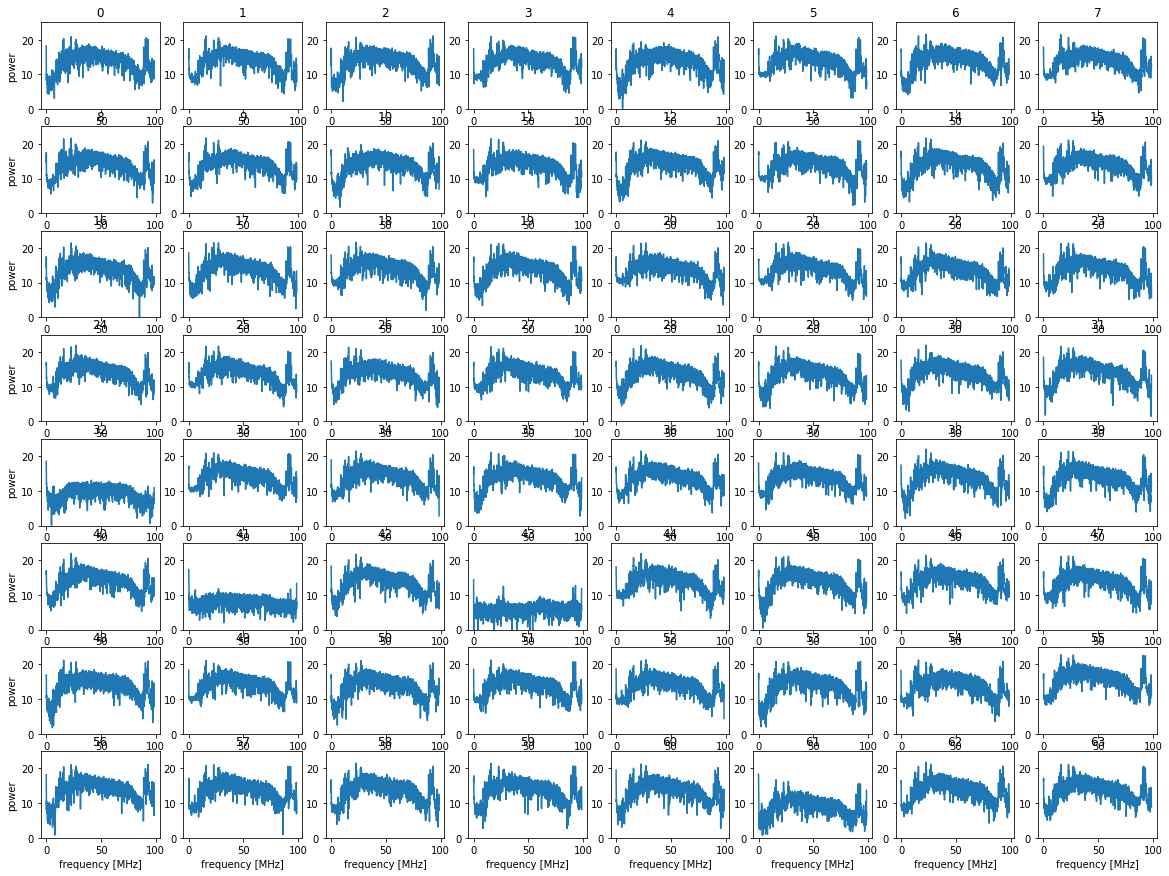

In [153]:

#Wednesday morning 10-6-2021 snapshot=np.load("/home/ubuntu/kplant/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1633546820.9389374.npy")
# ~1:40pm 10-6-2021 snapshot=np.load("/home/ubuntu/kplant/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1633552879.4008172.npy")

#1:54 pm
snapshot=np.load("/home/ubuntu/kplant/caltech-lwa/cosmic_ray_scripts/data_capture/snapshots/single_board_snapshot1633553600.5933795.npy")

#plot spectra
fbins=np.linspace(0,197/2,int(1+4096/2))

plt.figure(figsize=(20,15))
for i in range(64):
    plt.subplot(8,8,1+i)
    plt.title(i)
    spec=np.fft.rfft(snapshot[:,i+4])
    plt.plot(fbins,np.log(np.square(np.abs(spec))))
    plt.ylim(0,25)
    if i > 55:
        plt.xlabel('frequency [MHz]')
    if i%8==0:
        plt.ylabel('power')

In [ ]:
scipy.stats.normaltest()

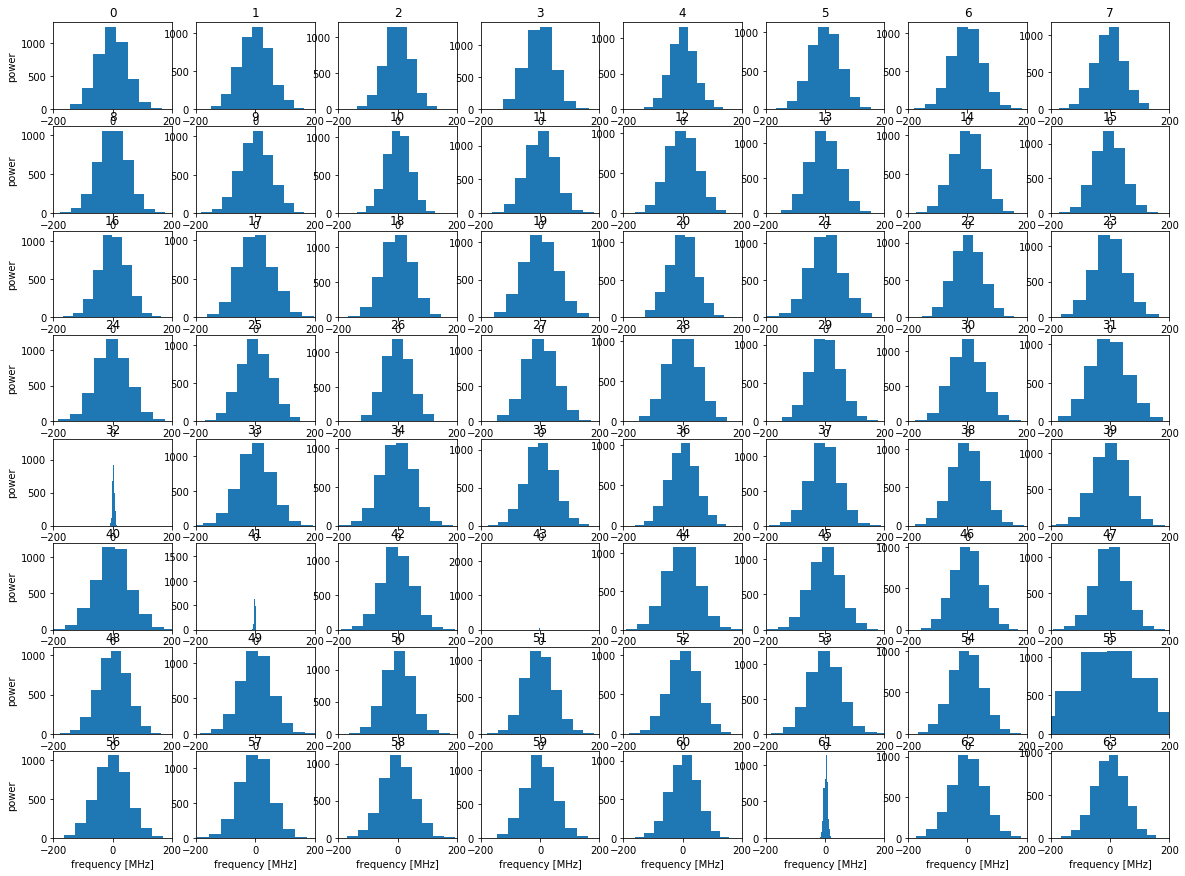

In [184]:
#plot histograms and test if Gaussian using scipy D'Angostino and Pearson test which uses skewness and kurtosis
fbins=np.linspace(0,197/2,int(1+4096/2))
isnormal=np.zeros(64)
plt.figure(figsize=(20,15))
for i in range(64):
    plt.subplot(8,8,1+i)
    plt.title(i)
    plt.hist(snapshot[:,i+4])
    isnormal[i] = st.normaltest(snapshot[:,i+4])[1]
    if i > 55:
        plt.xlabel('frequency [MHz]')
    if i%8==0:
        plt.ylabel('power')
    plt.xlim(-200,200)

[0.95403655 0.47173744 0.40504163 0.3849687  0.55632373 0.16421572
 0.52425309 0.30542816 0.62057704 0.39756604]


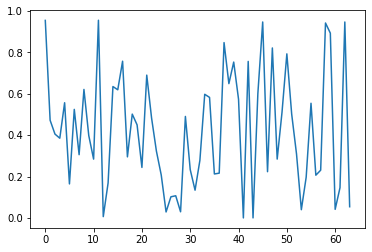

In [187]:
plt.plot(isnormal)
print(isnormal[:10])

## c. Fit Models to data 

In [238]:
n=2
savedthresholds=np.load("sky_thresholds_core"+str(n)+".npy")
savedvthresholds=np.load("sky_thresholds_veto"+str(n)+".npy")
savedresults_core=np.load("sky_results_core"+str(n)+".npy")
savedresults_veto=np.load("sky_results_veto"+str(n)+".npy")

Fit sigma only
[57.95899253]
[[0.20789919]]
Fit Sigma and Mean
[-0.6365848  57.95561688]
[[6.68061694e+10 7.33839734e+08]
 [7.33839734e+08 8.06094368e+06]]


Text(0.5, 0, 'Threshold')

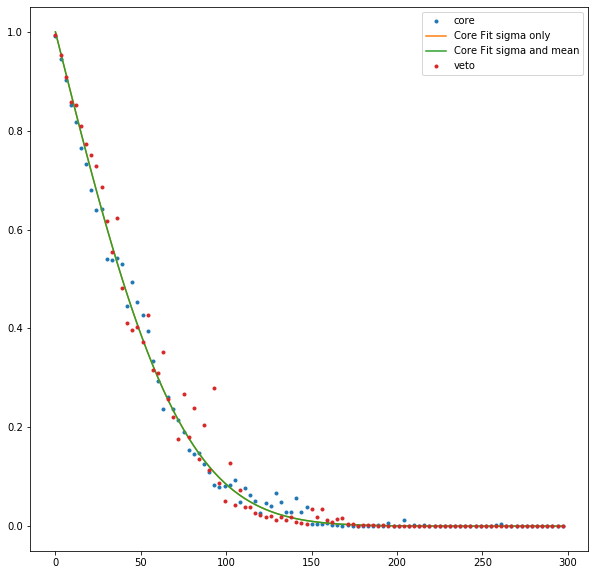

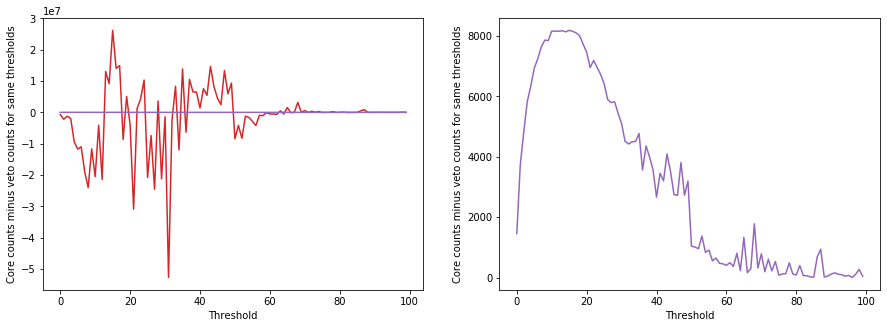

In [246]:
rate_core = savedresults_core/(2**28 - 1)
rate_veto = savedresults_veto/(2**28 - 1)

print("Fit sigma only")
popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[1,:])
print(popt1)
print(pcov1)

print("Fit Sigma and Mean")
p0=(0,10)
popt2,pcov2 = oz.curve_fit(prob,thresholds,rate_core[1,:],p0)
print(popt2)
print(pcov2)

model1 = prob_simple(thresholds,popt1[0])
model2 = prob(thresholds,popt2[0],popt2[1])

plt.figure(figsize=(10,10))
plt.plot(savedthresholds,rate_core[1,:],'.',label='core')
plt.plot(savedthresholds,model1,label="Core Fit sigma only")
plt.plot(savedthresholds,model2,label="Core Fit sigma and mean")


plt.plot(np.flip(savedthresholds),rate_veto[1,:],'.',label='veto')
plt.legend()

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(savedresults_core[1,:]-np.flip(savedresults_veto[1,:]),'C3',label="Core - veto")
plt.plot(binomial_error(rate_core[1,:],2**28),'C4',label="Estimate of uncertainty")
plt.ylabel("Core counts minus veto counts for same thresholds")
plt.xlabel("Threshold")

plt.subplot(122)
plt.plot(binomial_error(rate_core[1,:],2**28),'C4',label="Estimate of uncertainty")
plt.ylabel("Core counts minus veto counts for same thresholds")
plt.xlabel("Threshold")

The above model result is sensitivie to the initial guess when I fit mean and sigma.  When I made an initial quess of 50 for sigma, the fit failed really obviously badly.

### The difference between the core and veto is much much much larger than the error bars, unlike in the whitenoise case.
This plot may be more useful than some of the statistical tests and fits I tried.

Below, I fix the mean at zero and only fit sigma, but I fit core and veto separately. This is still just one antenna.

Fit sigma only
[19.31966433]
[[0.02309992]]
Fit Veto
[20.01186997]
[[0.05746415]]


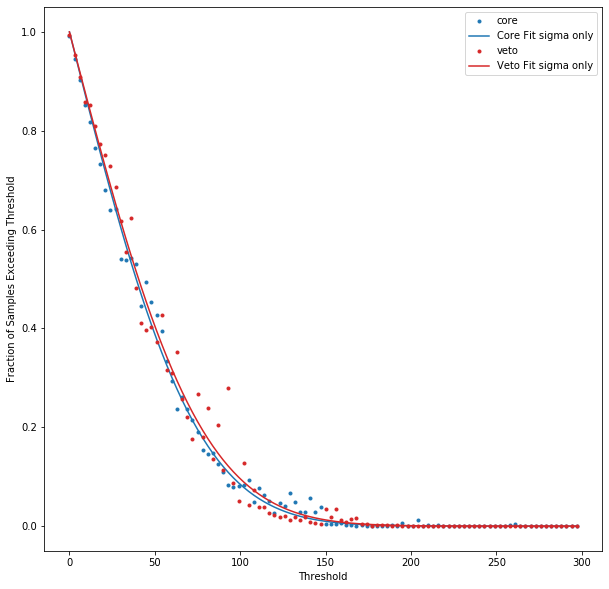

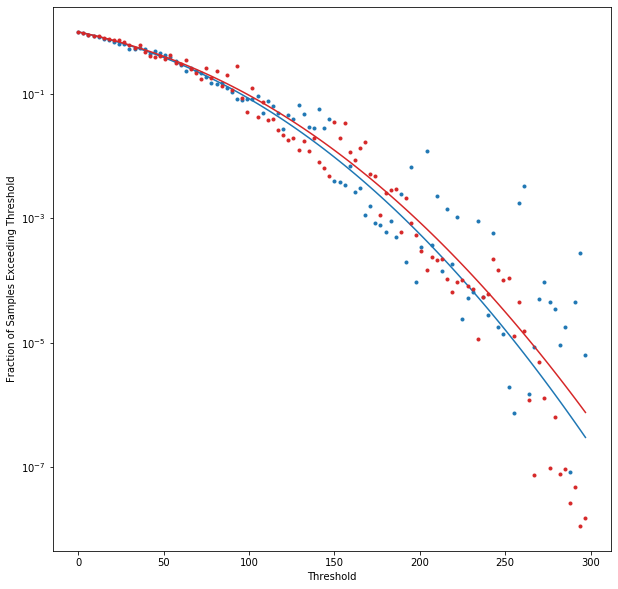

In [146]:
rate_core = savedresults_core/(2**28 - 1)
rate_veto = savedresults_veto/(2**28 - 1)

print("Fit sigma only")
popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[1,:])
print(popt1)
print(pcov1)

print("Fit Veto")
popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[1,:]))
print(popt2)
print(pcov2)

model1 = prob_simple(thresholds,popt1[0])
model2 = prob_simple(thresholds,popt2[0])

plt.figure(figsize=(10,10))
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.plot(savedthresholds,rate_core[1,:],'C0.',label='core')
plt.plot(savedthresholds,model1,'C0-',label="Core Fit sigma only")

plt.plot(np.flip(savedthresholds),rate_veto[1,:],'C3.',label='veto')
plt.plot(savedthresholds,model2,'C3-',label="Veto Fit sigma only")

plt.legend()

plt.figure(figsize=(10,10))
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.semilogy(savedthresholds,rate_core[1,:],'C0.',label='core')
plt.semilogy(savedthresholds,model1,'C0-',label="Core Fit sigma only")

plt.semilogy(np.flip(savedthresholds),rate_veto[1,:],'C3.',label='veto')
plt.semilogy(savedthresholds,model2,'C3-',label="Veto Fit sigma only")



0
Fit Core
[17.53736998]
[[0.01457118]]
Fit Veto
[18.90476234]
[[0.05555004]]


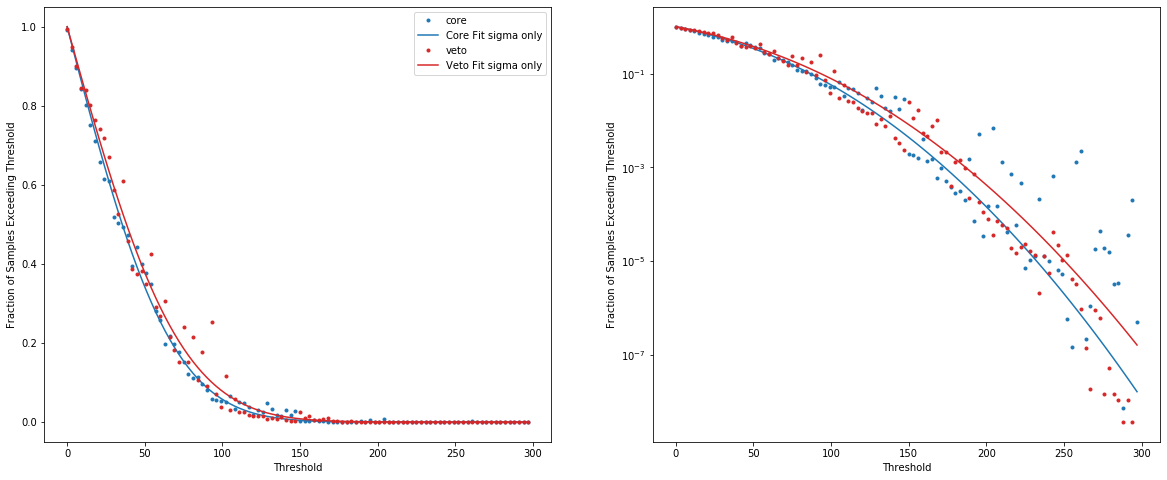

1
Fit Core
[19.31966433]
[[0.02309992]]
Fit Veto
[20.01186997]
[[0.05746415]]


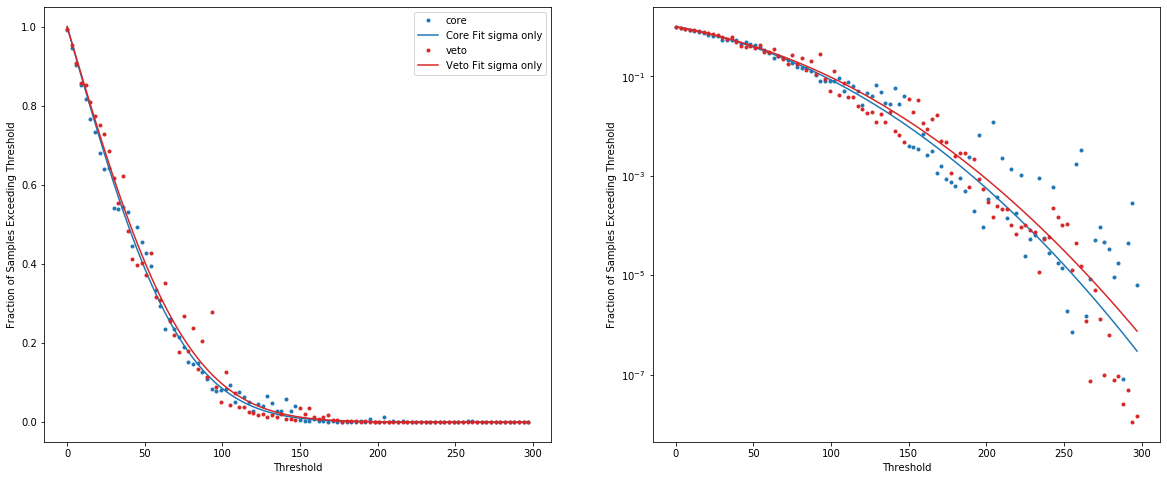

2
Fit Core
[17.89045031]
[[0.03095194]]
Fit Veto
[19.88525092]
[[0.12635443]]


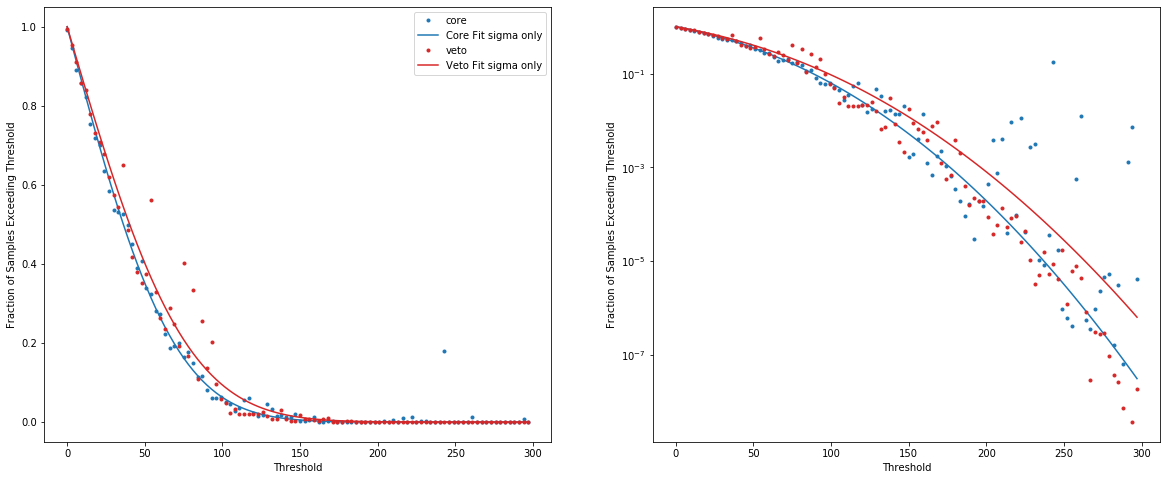

3
Fit Core
[18.33691617]
[[0.01522805]]
Fit Veto
[19.43172724]
[[0.04906913]]


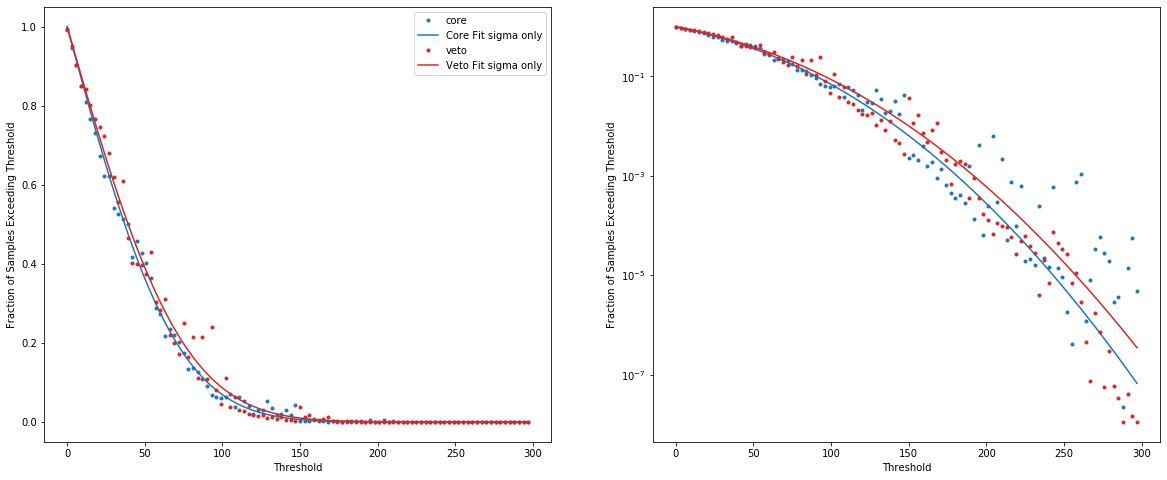

4
Fit Core
[16.56109166]
[[0.02026016]]
Fit Veto
[18.3414578]
[[0.0739372]]


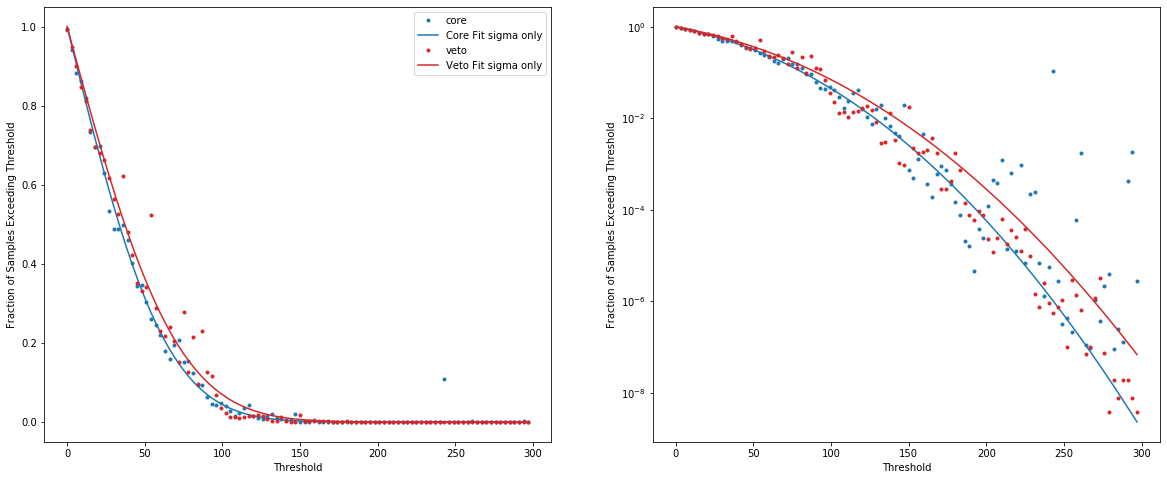

5
Fit Core
[14.48390576]
[[0.00382546]]
Fit Veto
[14.40899031]
[[0.00179499]]


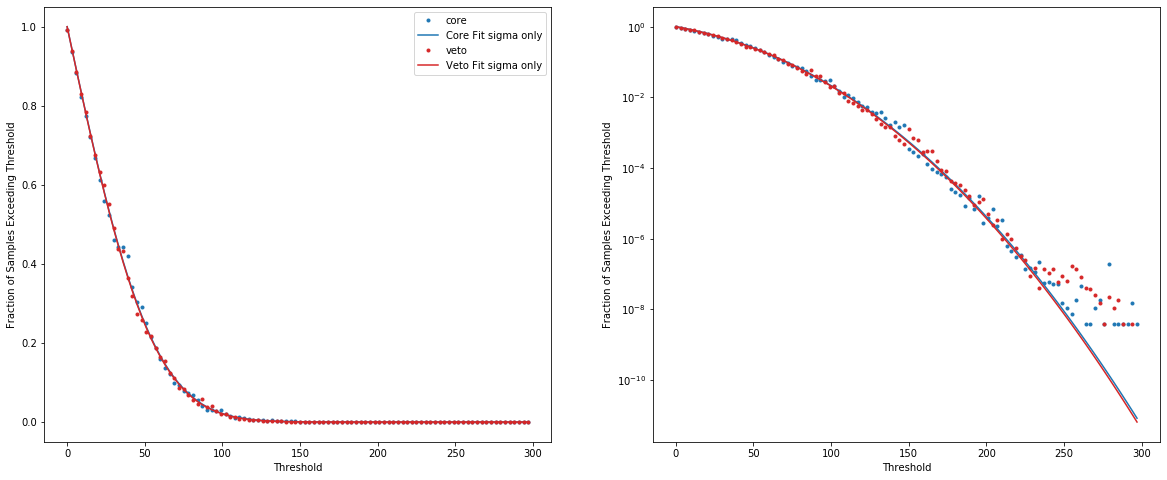

6
Fit Core
[17.53608739]
[[0.01808637]]
Fit Veto
[19.17303538]
[[0.07959899]]


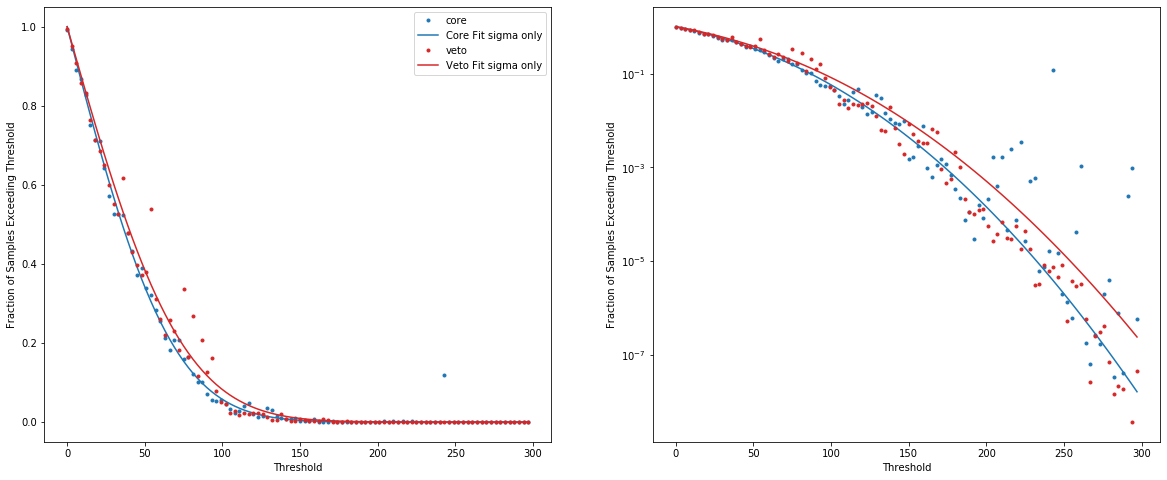

7
Fit Core
[18.47607535]
[[0.02042787]]
Fit Veto
[19.68511758]
[[0.04807091]]


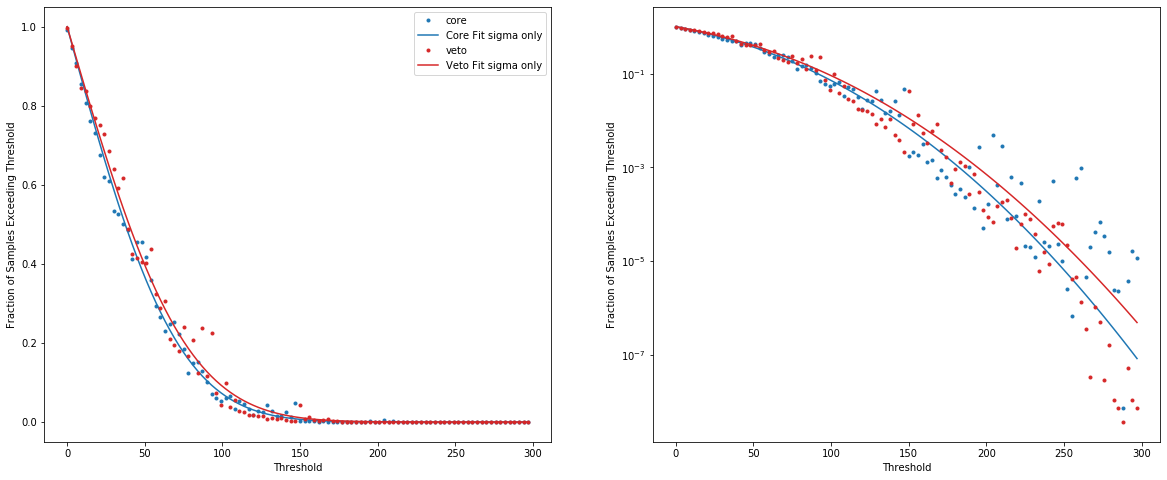

8
Fit Core
[17.17467326]
[[0.01473824]]
Fit Veto
[18.85454776]
[[0.06828986]]


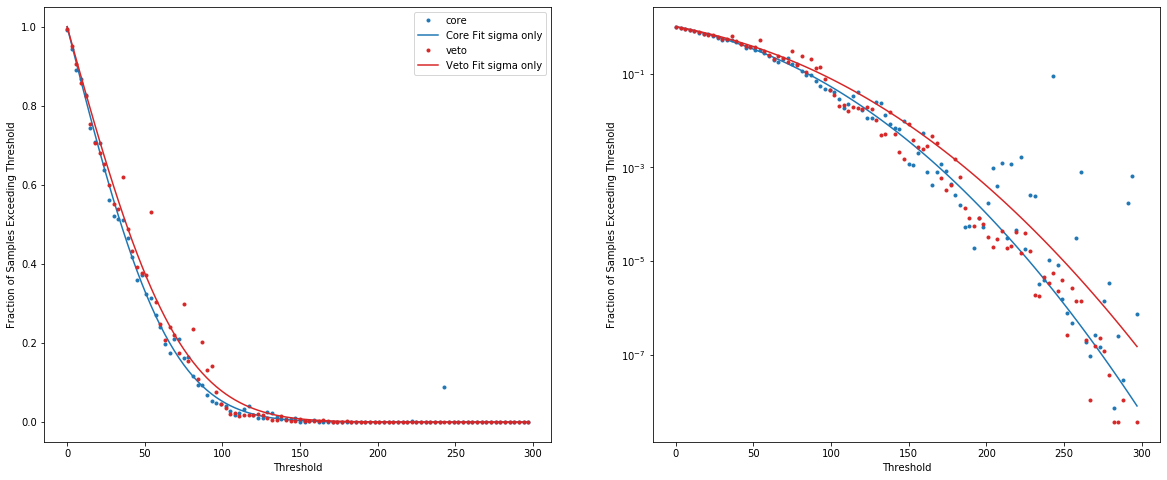

9
Fit Core
[18.44188551]
[[0.01828993]]
Fit Veto
[19.50043066]
[[0.04578463]]


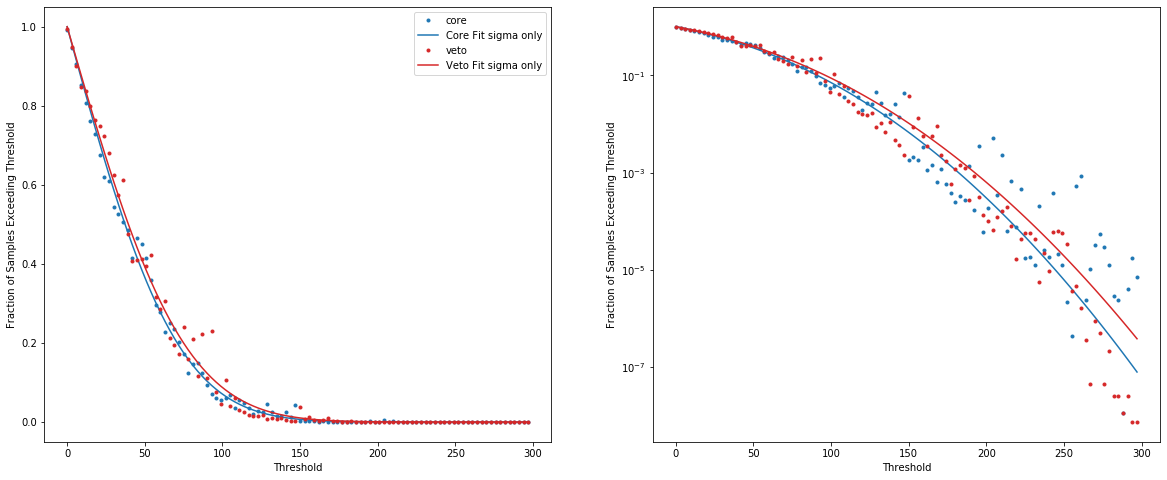

10
Fit Core
[18.36163007]
[[0.03672295]]
Fit Veto
[20.30565524]
[[0.13070135]]


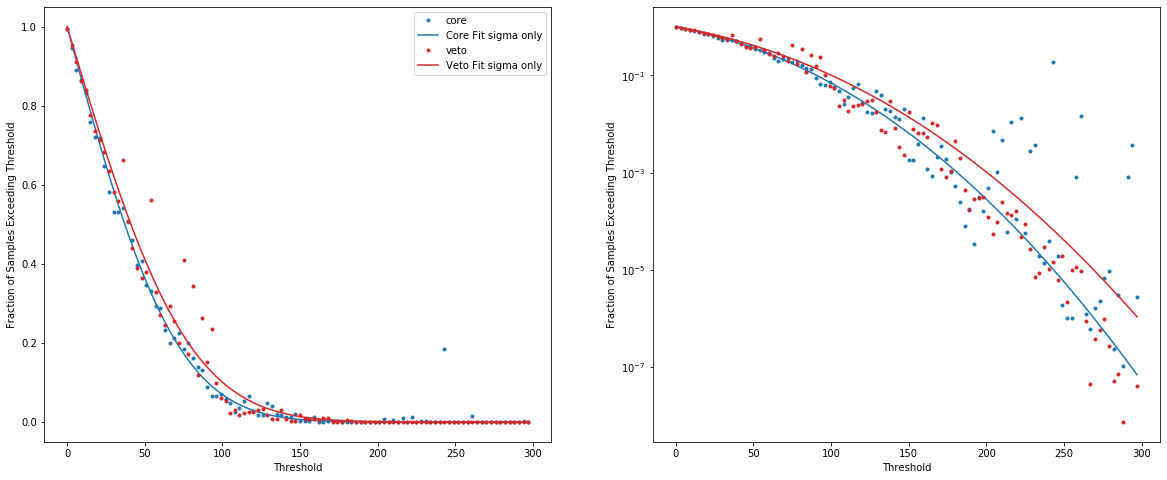

11
Fit Core
[14.48394477]
[[0.00194665]]
Fit Veto
[14.73198323]
[[0.00276905]]


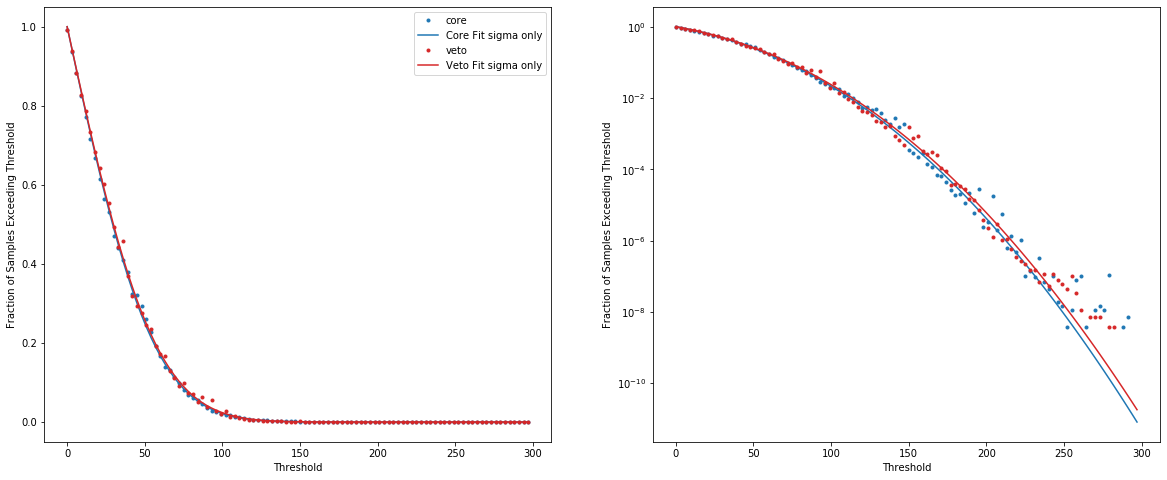

12
Fit Core
[17.65483256]
[[0.03118781]]
Fit Veto
[19.93020115]
[[0.12995553]]


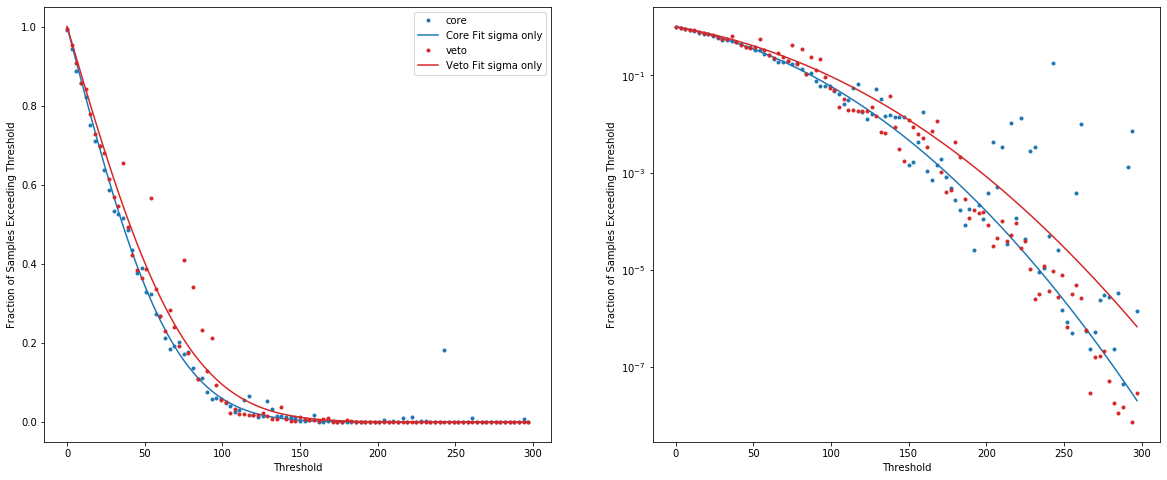

13
Fit Core
[16.26825984]
[[0.00745445]]
Fit Veto
[17.16868927]
[[0.02494308]]


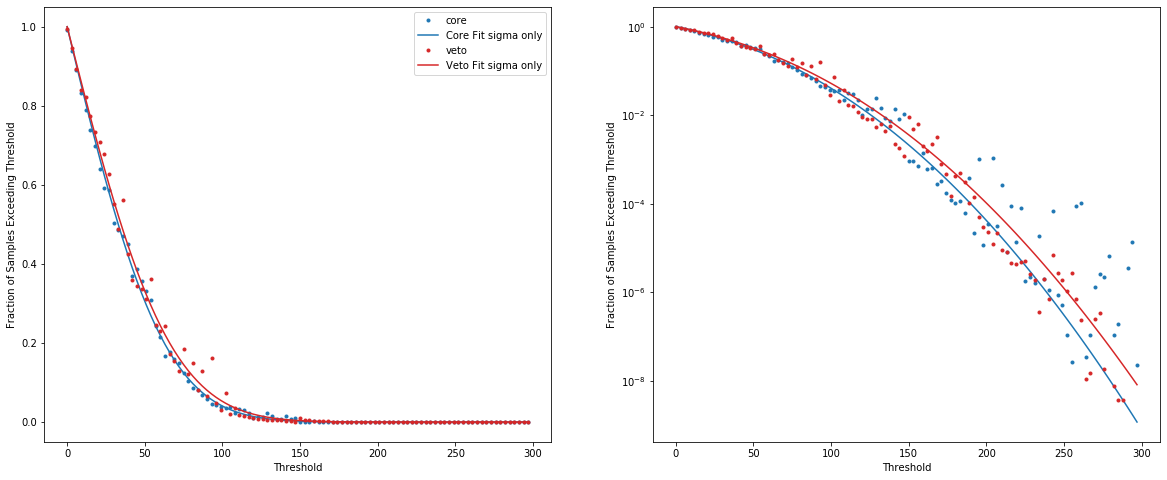

14
Fit Core
[18.11982238]
[[0.03850698]]
Fit Veto
[20.22935441]
[[0.15151958]]


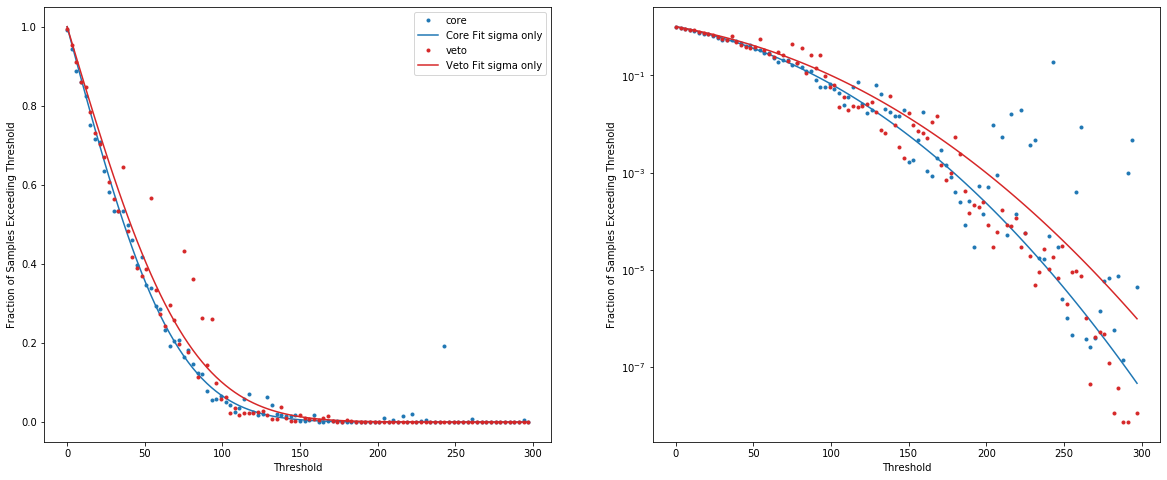

15
Fit Core
[16.4841868]
[[0.01524529]]
Fit Veto
[18.45286322]
[[0.08694403]]


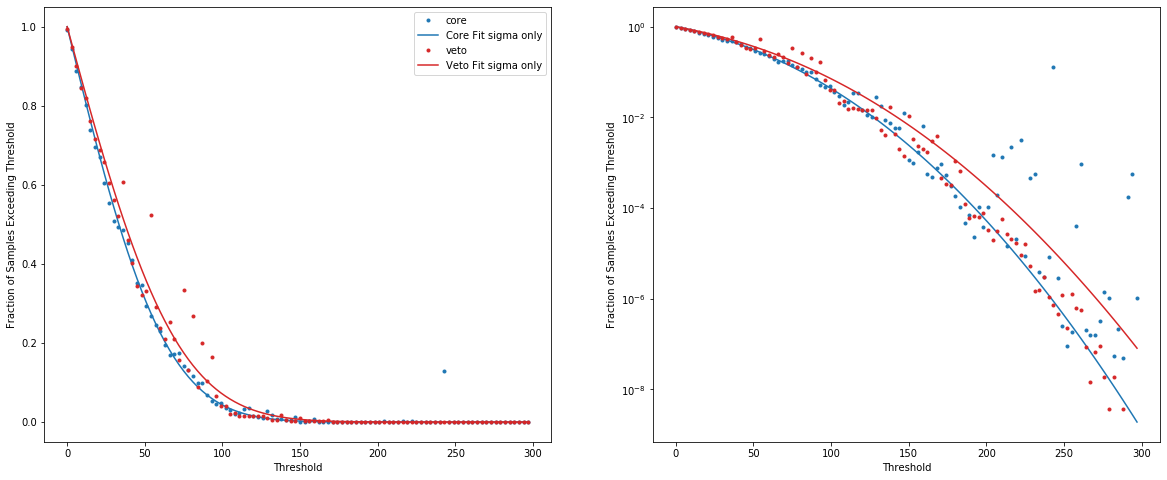

16
Fit Core
[22.0966799]
[[0.0795515]]
Fit Veto
[24.01886405]
[[0.19987057]]


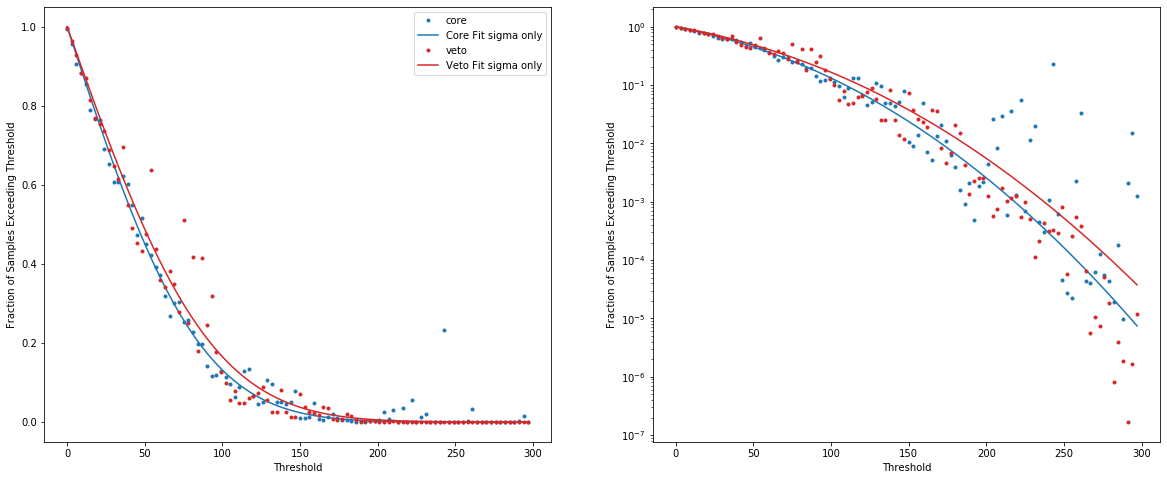

17
Fit Core
[20.91693221]
[[0.03446994]]
Fit Veto
[21.74699423]
[[0.0763981]]


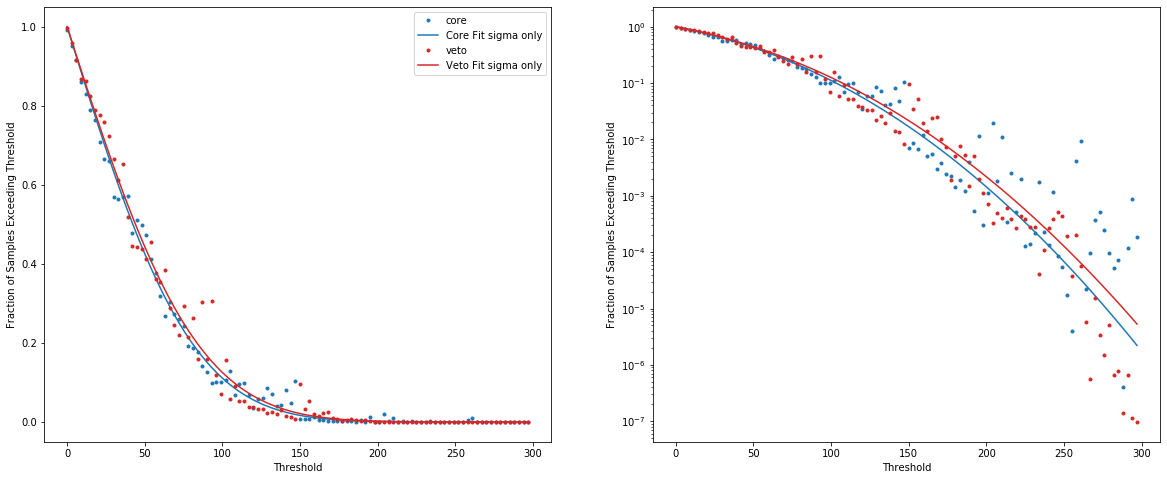

18
Fit Core
[18.13184629]
[[0.04192016]]
Fit Veto
[19.82859787]
[[0.14173825]]


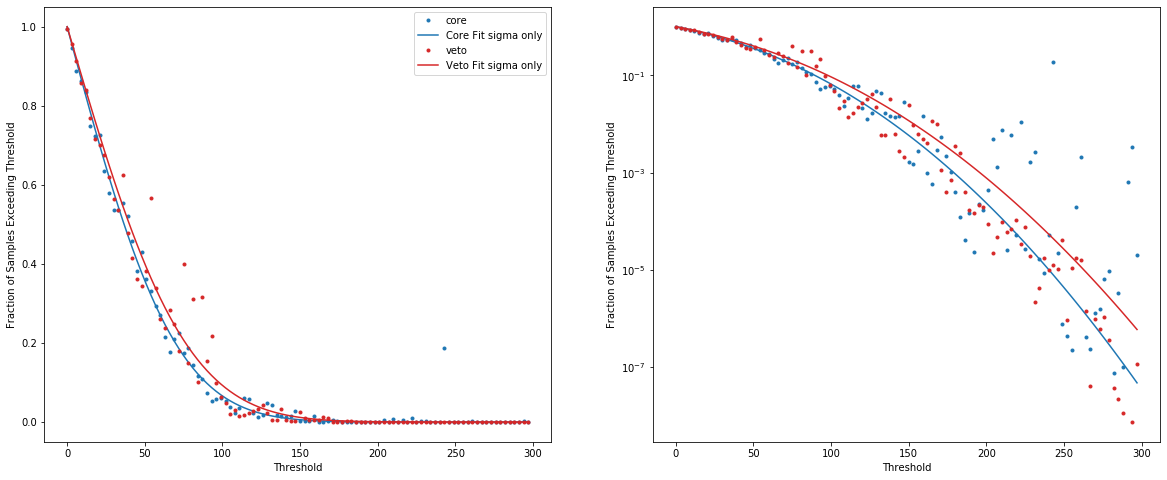

19
Fit Core
[18.9799379]
[[0.02520535]]
Fit Veto
[19.90488275]
[[0.05989767]]


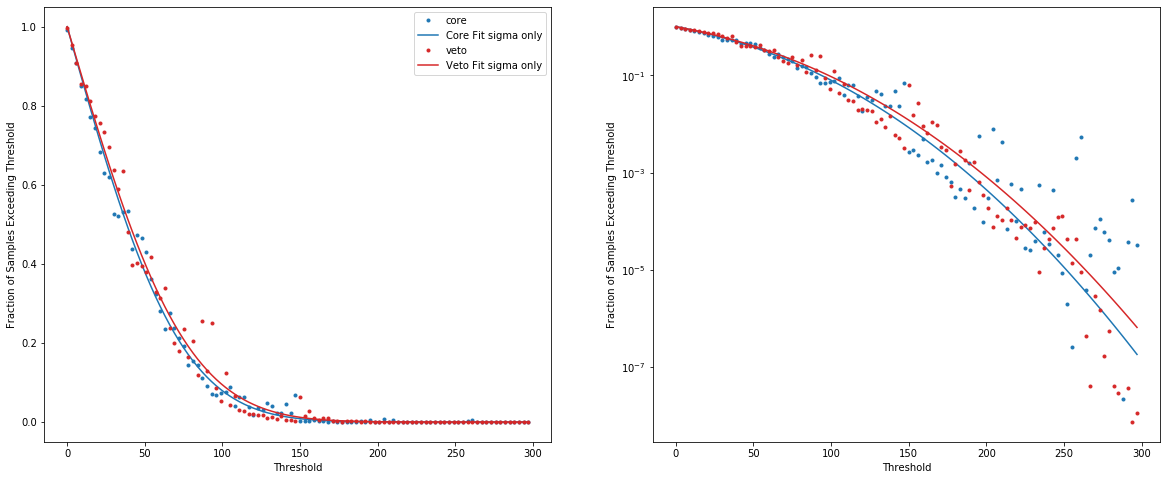

20
Fit Core
[18.74350072]
[[0.04588904]]
Fit Veto
[20.57968709]
[[0.15237567]]


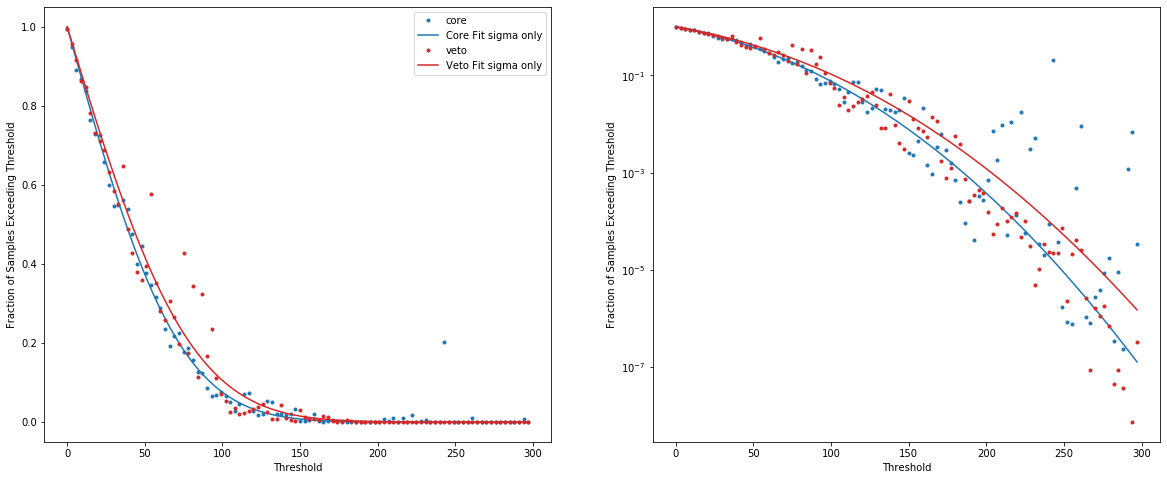

21
Fit Core
[16.33307461]
[[0.02231459]]
Fit Veto
[17.98241217]
[[0.04382718]]


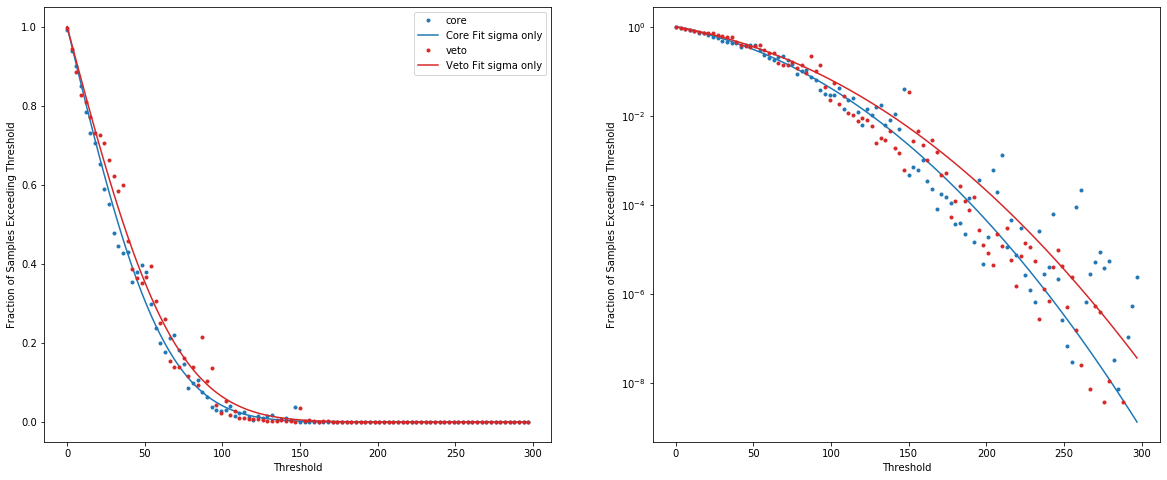

22
Fit Core
[19.91012125]
[[0.05267927]]
Fit Veto
[21.58488273]
[[0.15307473]]


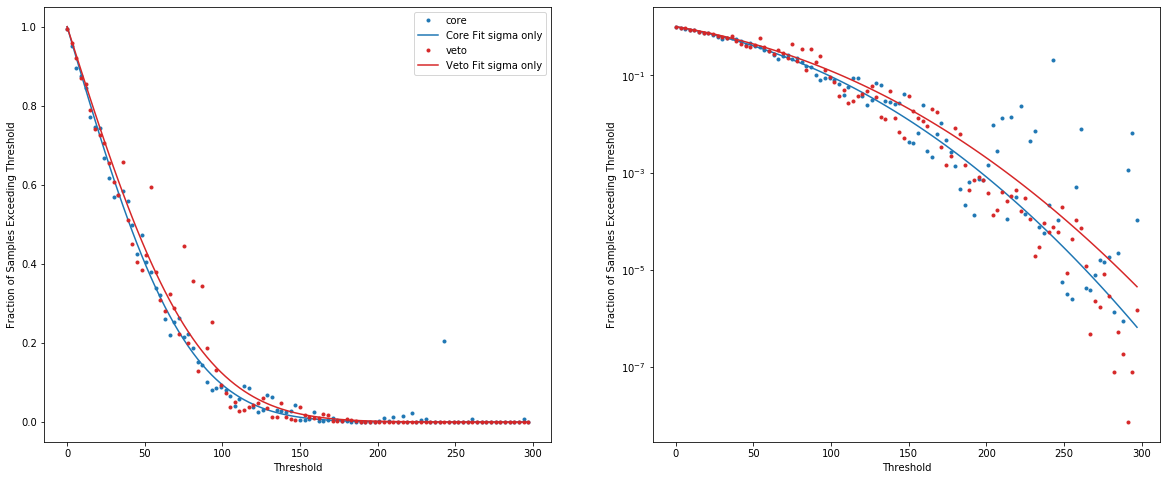

23
Fit Core
[19.79613596]
[[0.02469301]]
Fit Veto
[20.2280663]
[[0.04534906]]


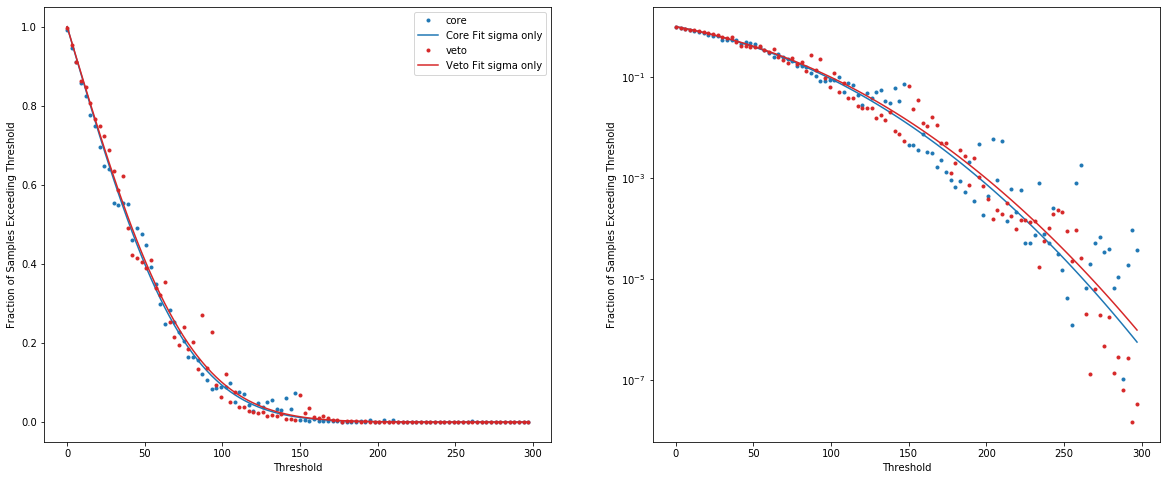

24
Fit Core
[19.39993765]
[[0.05554834]]
Fit Veto
[21.53595913]
[[0.1836098]]


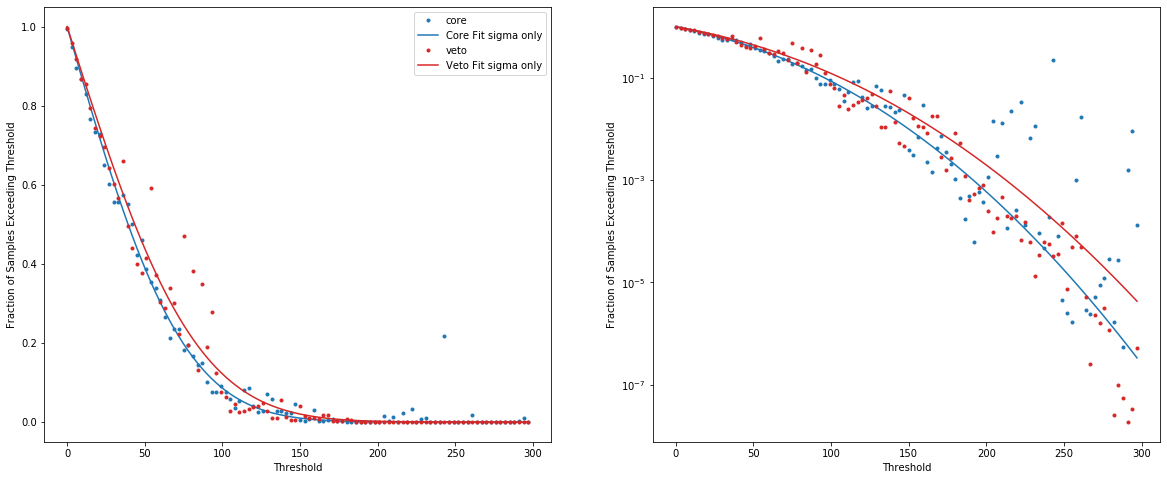

25
Fit Core
[18.06699183]
[[0.02655561]]
Fit Veto
[19.03892068]
[[0.06738308]]


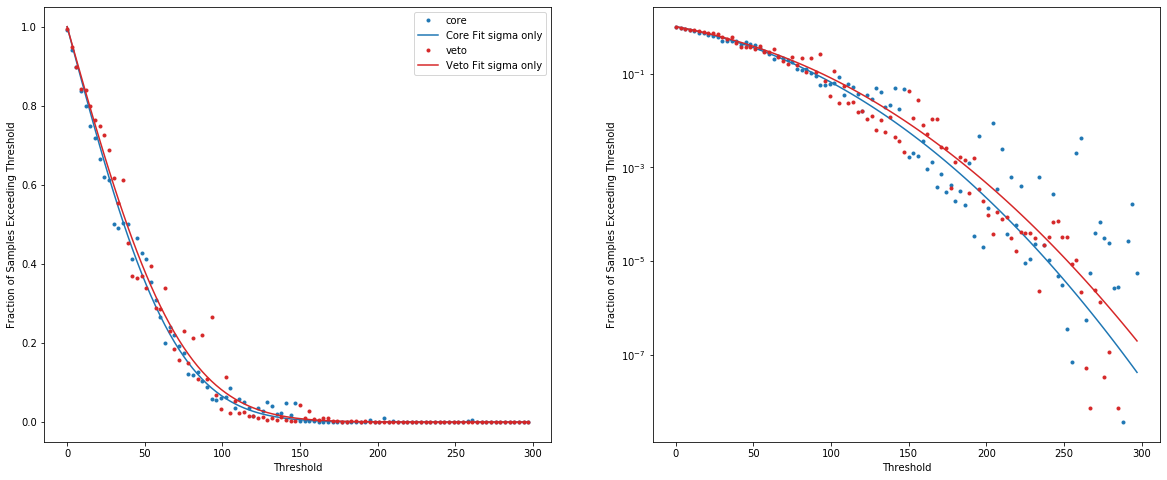

26
Fit Core
[18.77114308]
[[0.04825391]]
Fit Veto
[20.62889292]
[[0.1593331]]


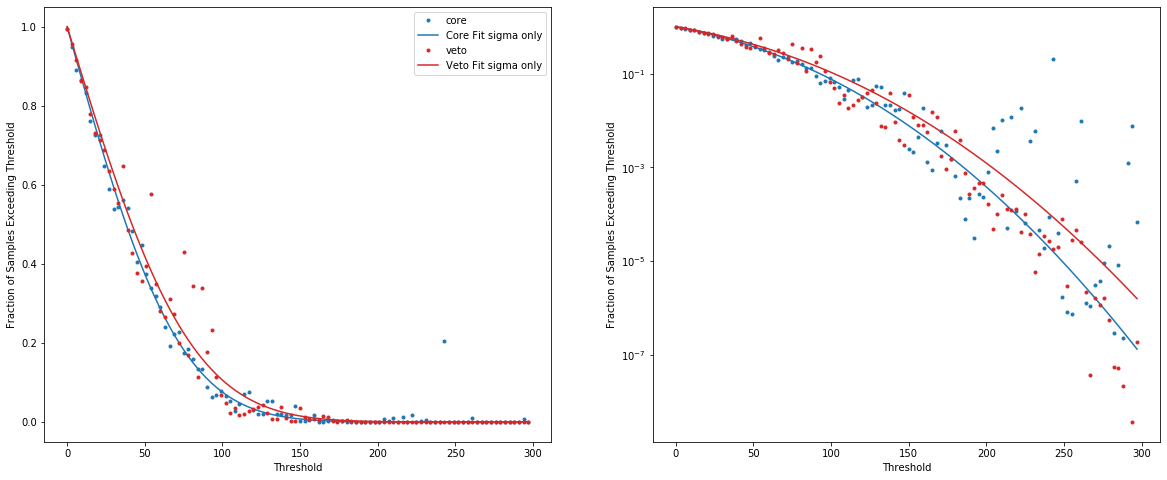

27
Fit Core
[17.39708942]
[[0.02379417]]
Fit Veto
[18.2010527]
[[0.04838166]]


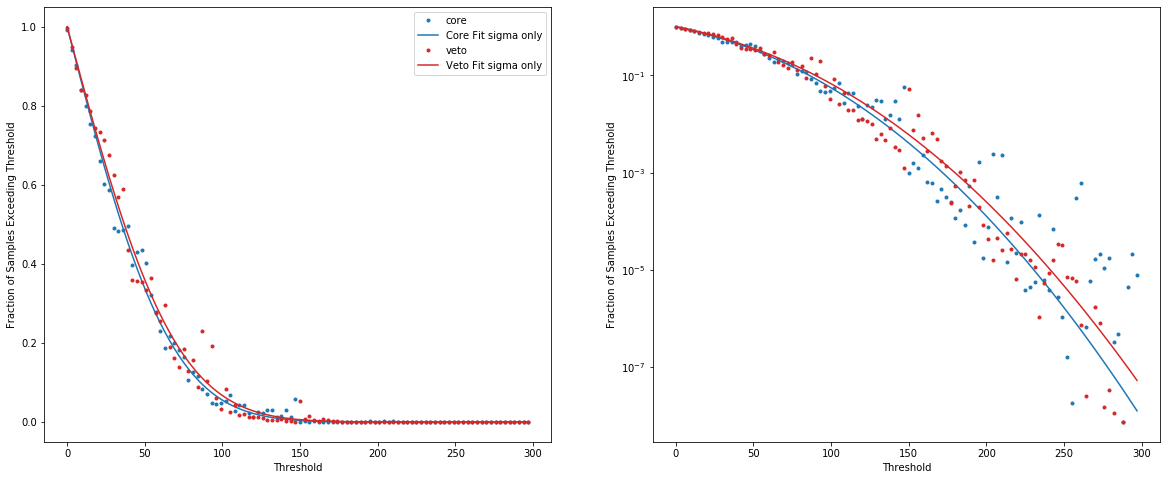

28
Fit Core
[19.82794559]
[[0.05194709]]
Fit Veto
[21.69990669]
[[0.16609094]]


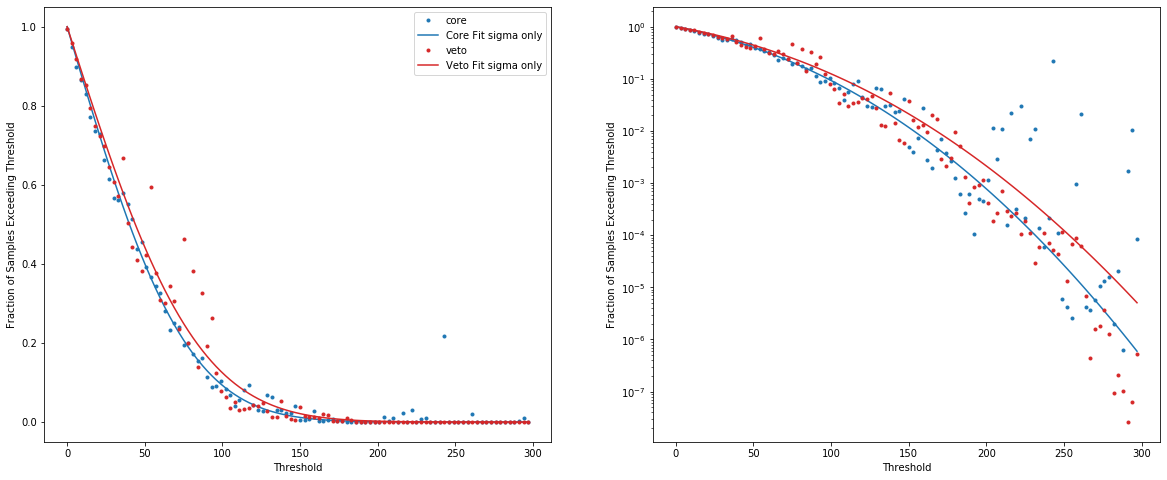

29
Fit Core
[19.19318772]
[[0.02548487]]
Fit Veto
[20.2629769]
[[0.06399729]]


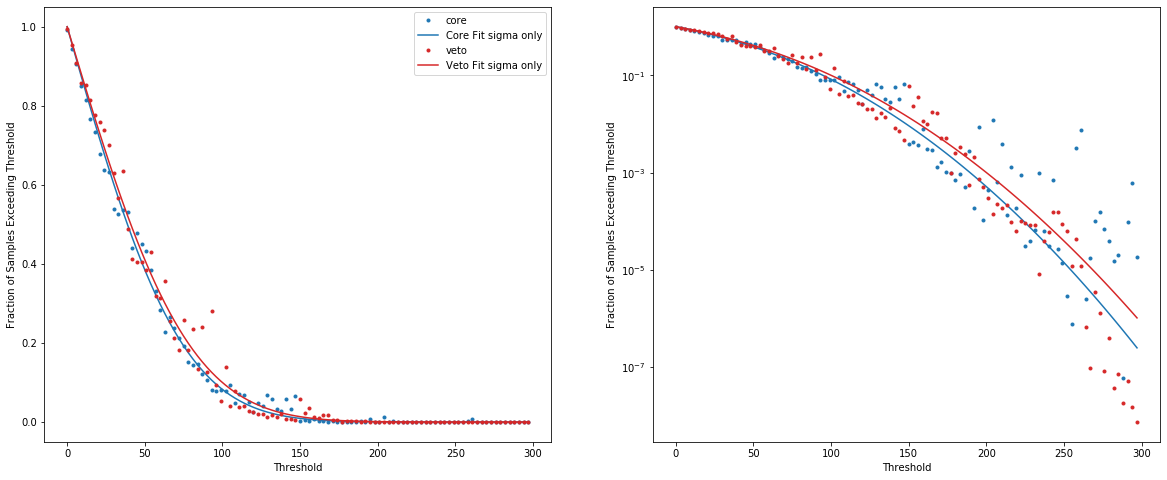

30
Fit Core
[19.74050626]
[[0.05338375]]
Fit Veto
[21.77370066]
[[0.1694293]]


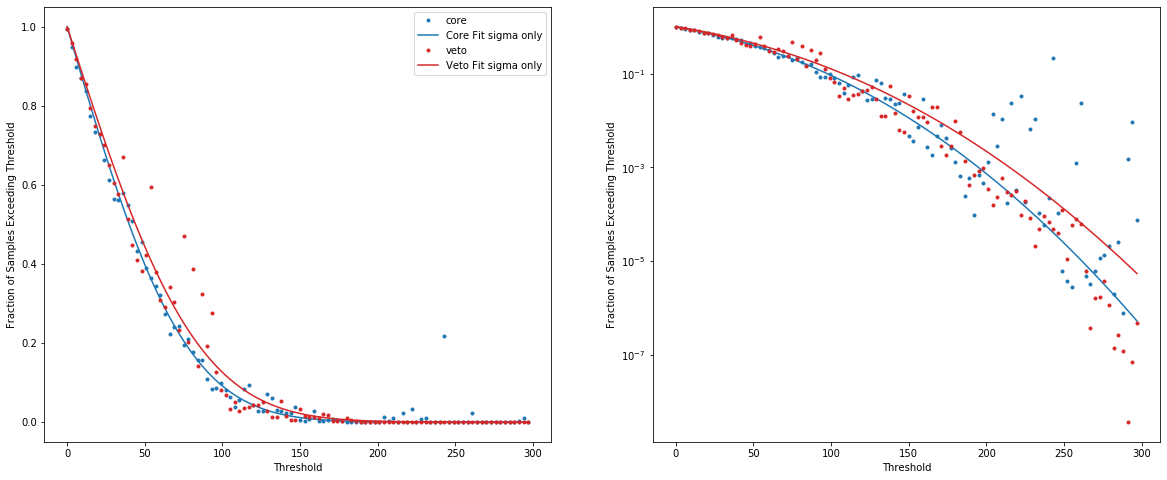

31
Fit Core
[17.47928592]
[[0.01845996]]
Fit Veto
[18.43677896]
[[0.05041884]]


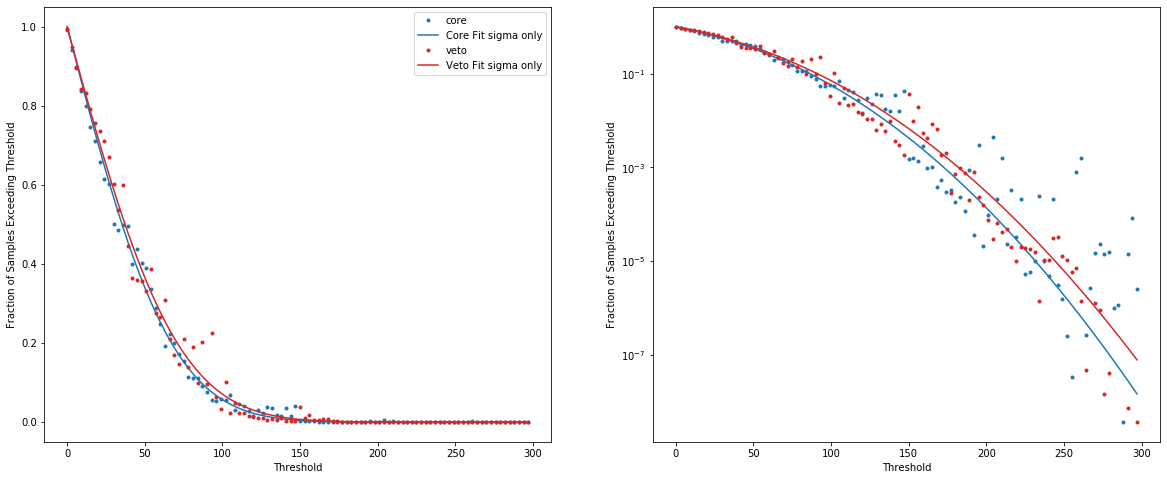

32
Fit Core
[17.81595571]
[[0.03773991]]
Fit Veto
[19.84120805]
[[0.15169431]]


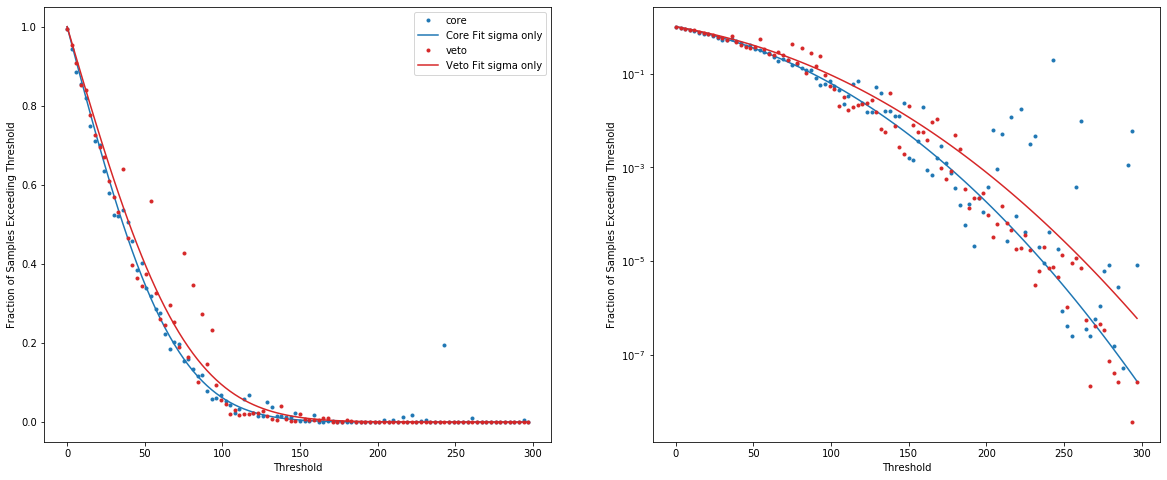

33
Fit Core
[18.36944619]
[[0.01910065]]
Fit Veto
[19.24888213]
[[0.04499675]]


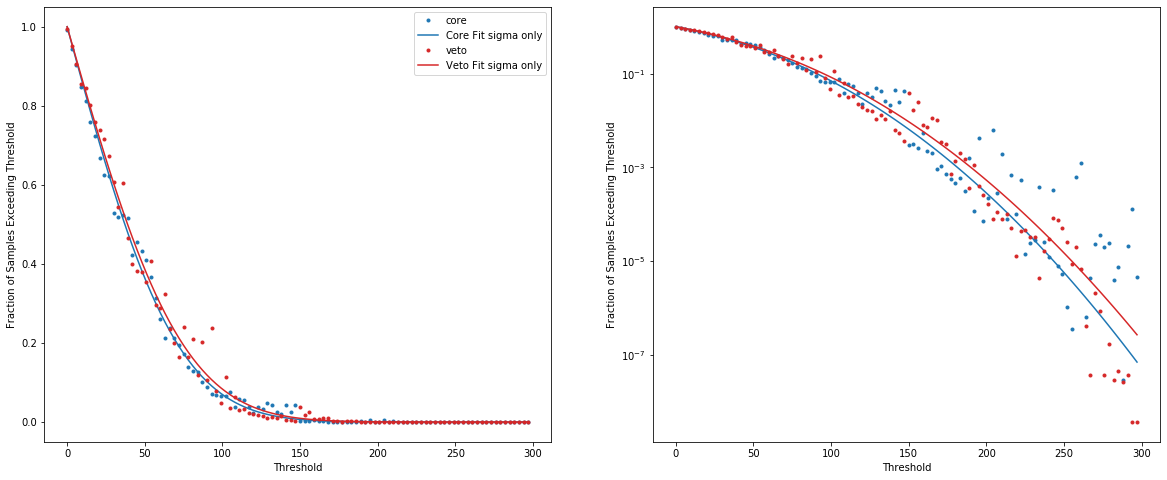

34
Fit Core
[19.6330385]
[[0.05300827]]
Fit Veto
[21.33064902]
[[0.16872549]]


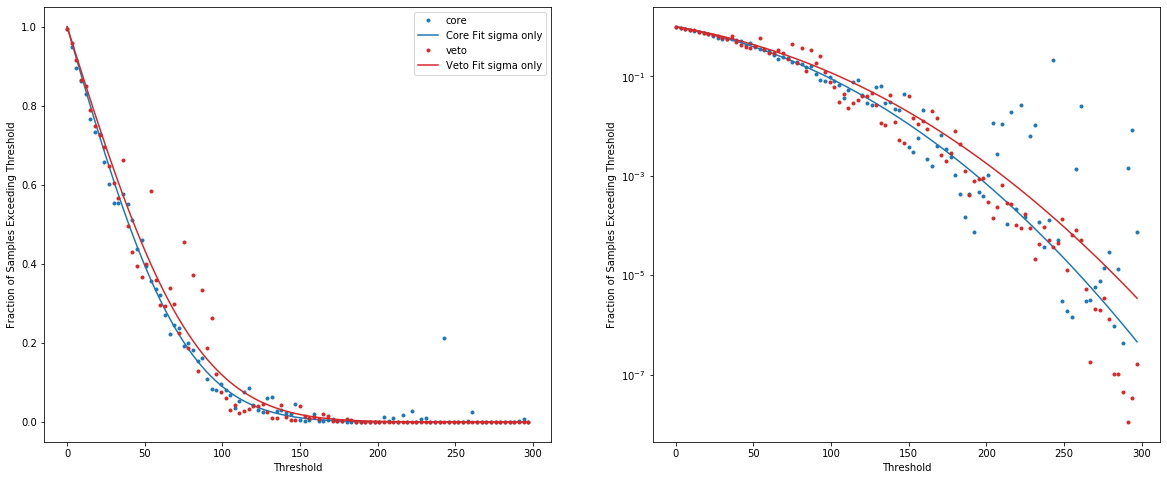

35
Fit Core
[20.08076903]
[[0.04047867]]
Fit Veto
[20.94671641]
[[0.08571684]]


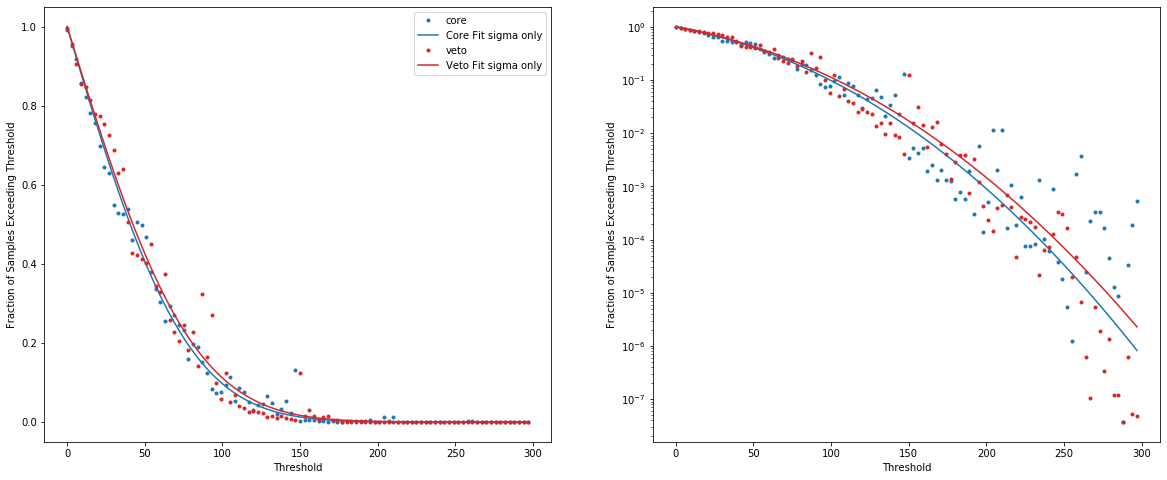

36
Fit Core
[0.23245013]
[[279.50477623]]
Fit Veto
[0.25717234]
[[54.26249415]]


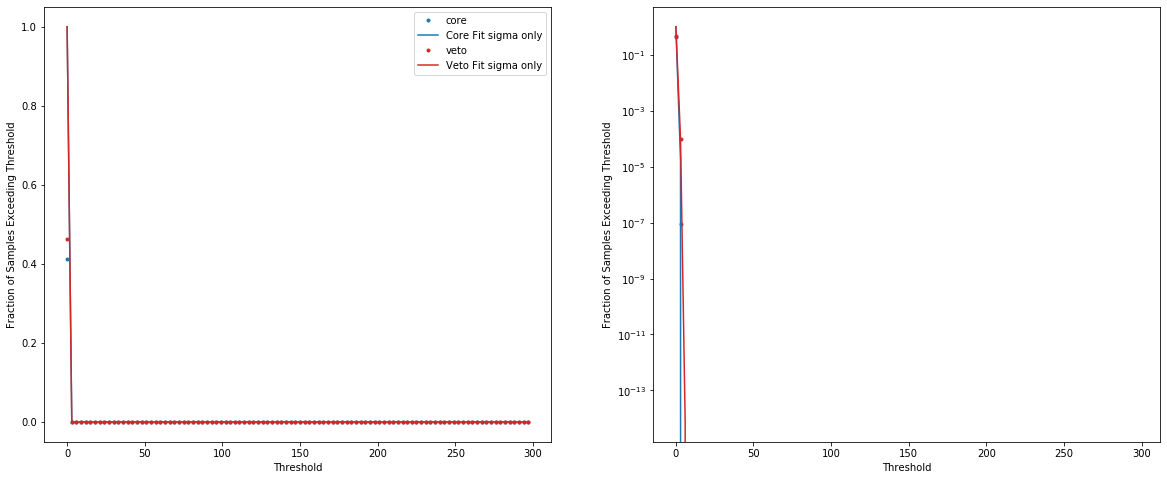

37
Fit Core
[18.28272239]
[[0.02206752]]
Fit Veto
[19.14149174]
[[0.04830438]]


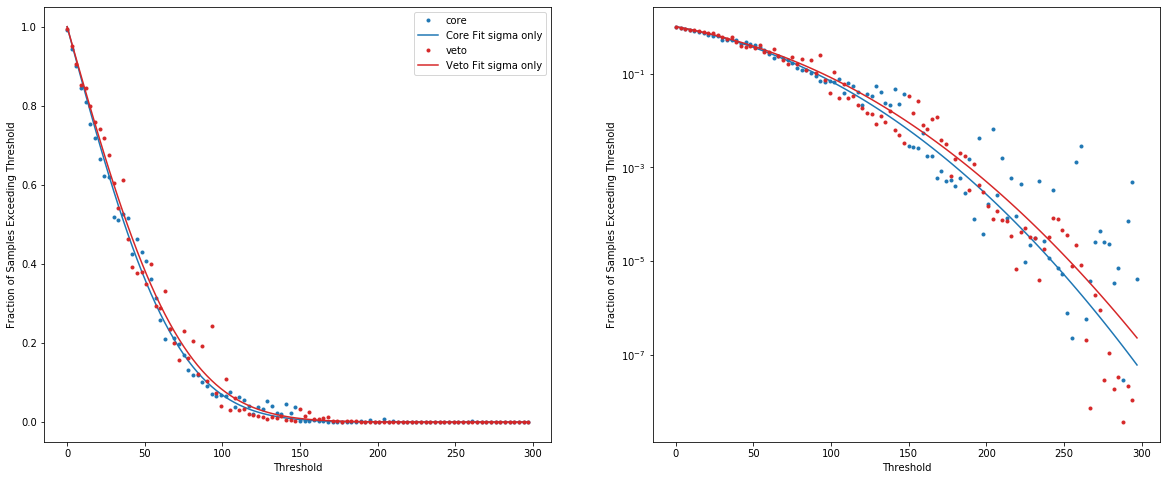

38
Fit Core
[0.82853974]
[[0.0007785]]
Fit Veto
[0.84172281]
[[0.00079253]]


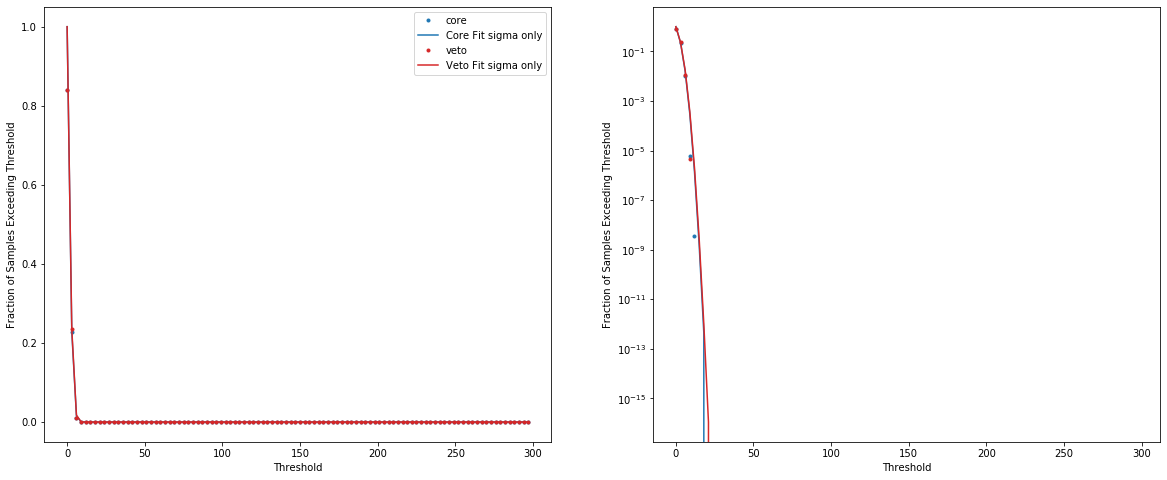

39
Fit Core
[20.34118255]
[[0.03186662]]
Fit Veto
[21.15621583]
[[0.07822926]]


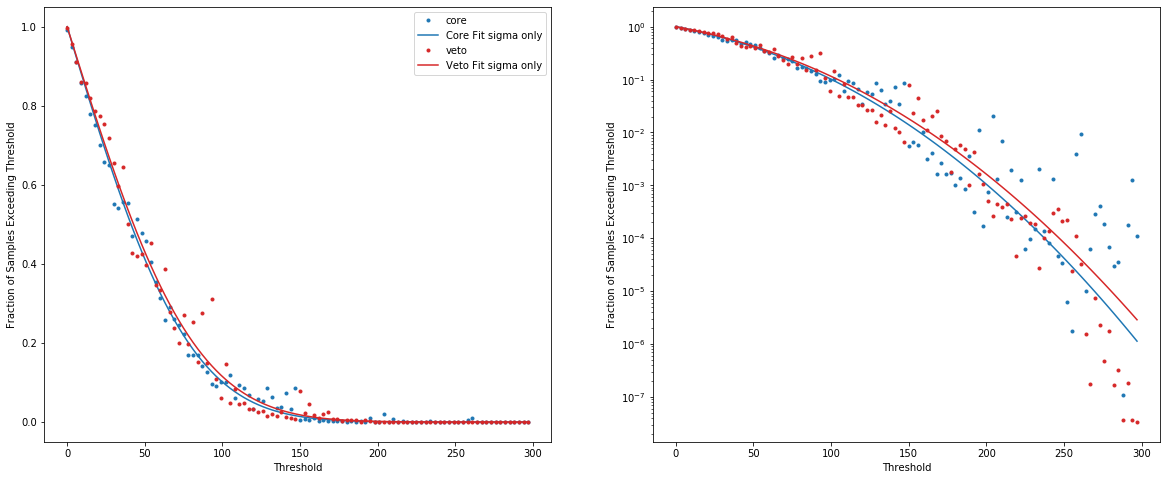

40
Fit Core
[19.75386101]
[[0.05295828]]
Fit Veto
[21.4093213]
[[0.15400448]]


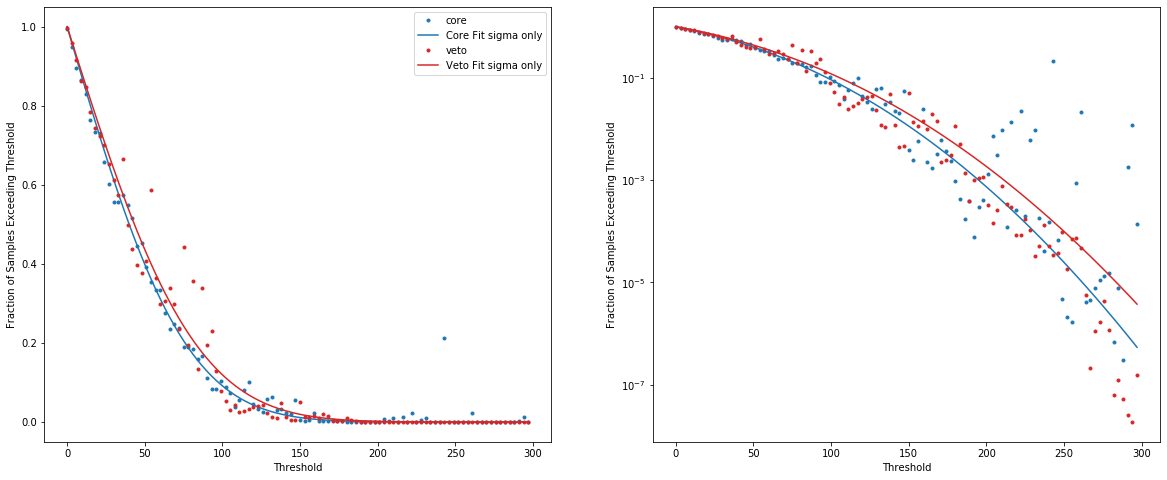

41
Fit Core
[18.93147881]
[[0.02538047]]
Fit Veto
[20.13681325]
[[0.07638153]]


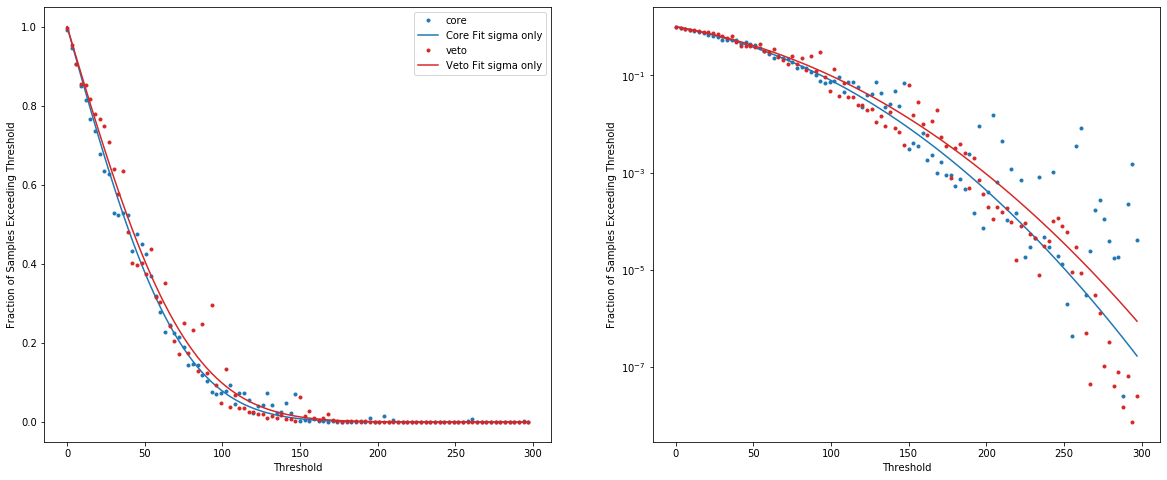

42
Fit Core
[18.37137099]
[[0.04050951]]
Fit Veto
[20.33232686]
[[0.16447639]]


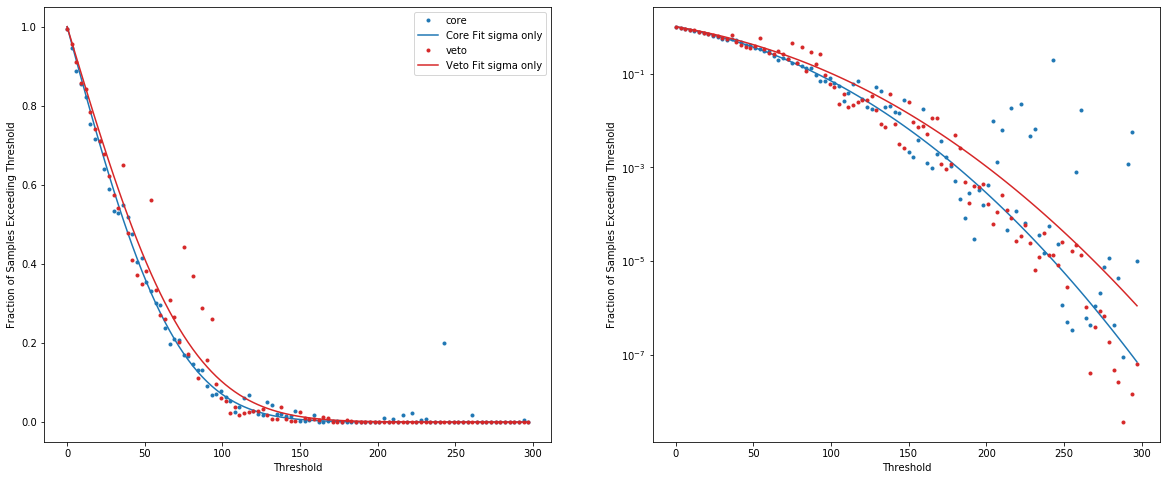

43
Fit Core
[17.00314754]
[[0.0181123]]
Fit Veto
[18.01142774]
[[0.04281919]]


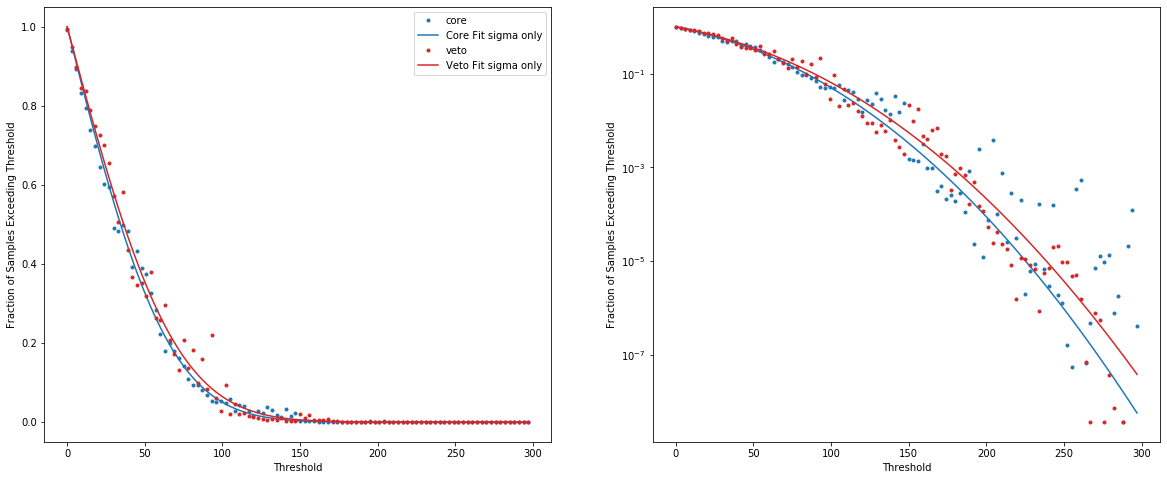

44
Fit Core
[19.11304277]
[[0.04726437]]
Fit Veto
[21.03389798]
[[0.15939188]]


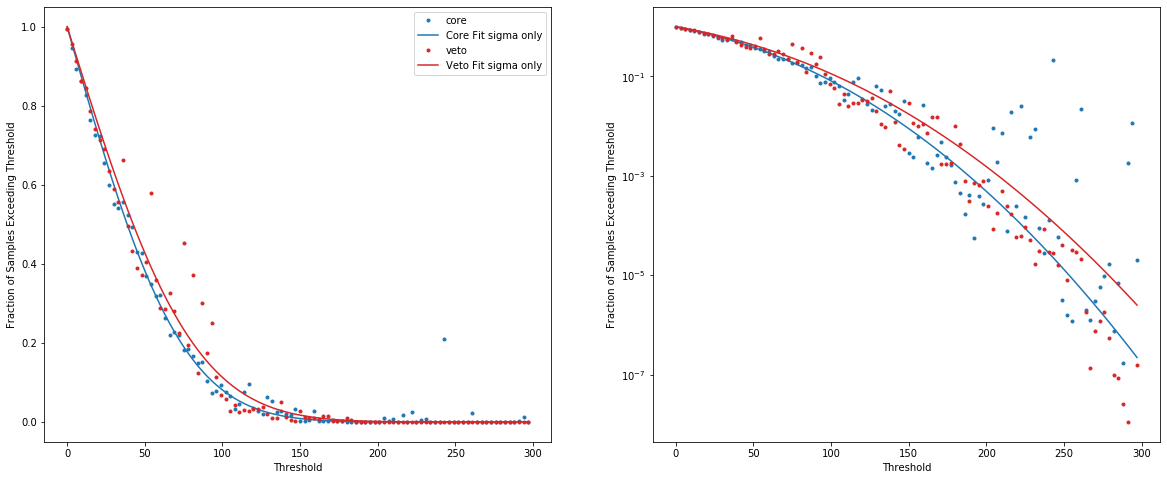

45
Fit Core
[19.28515411]
[[0.02477394]]
Fit Veto
[20.62017554]
[[0.06855088]]


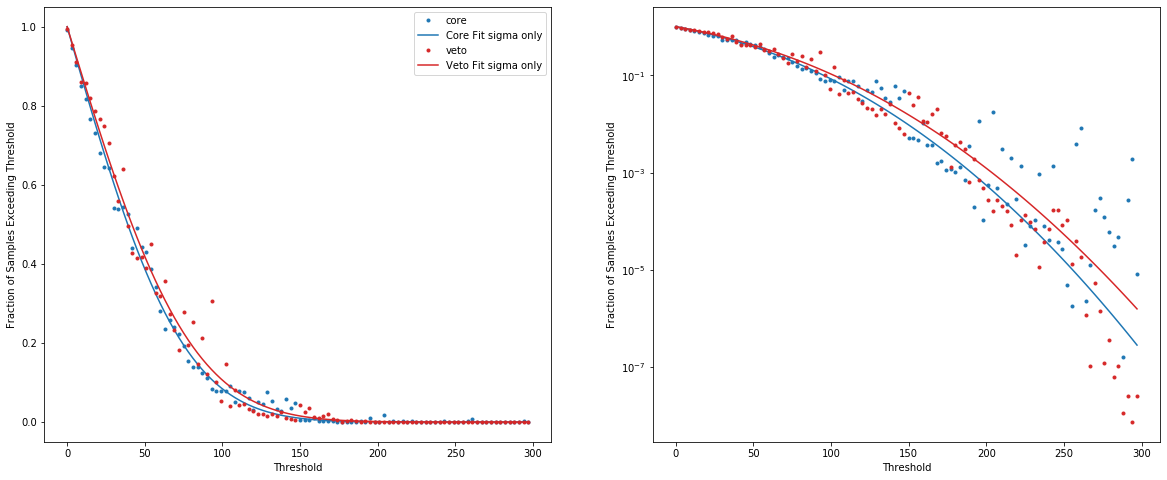

46
Fit Core
[20.45215871]
[[0.05434755]]
Fit Veto
[22.15926875]
[[0.16333038]]


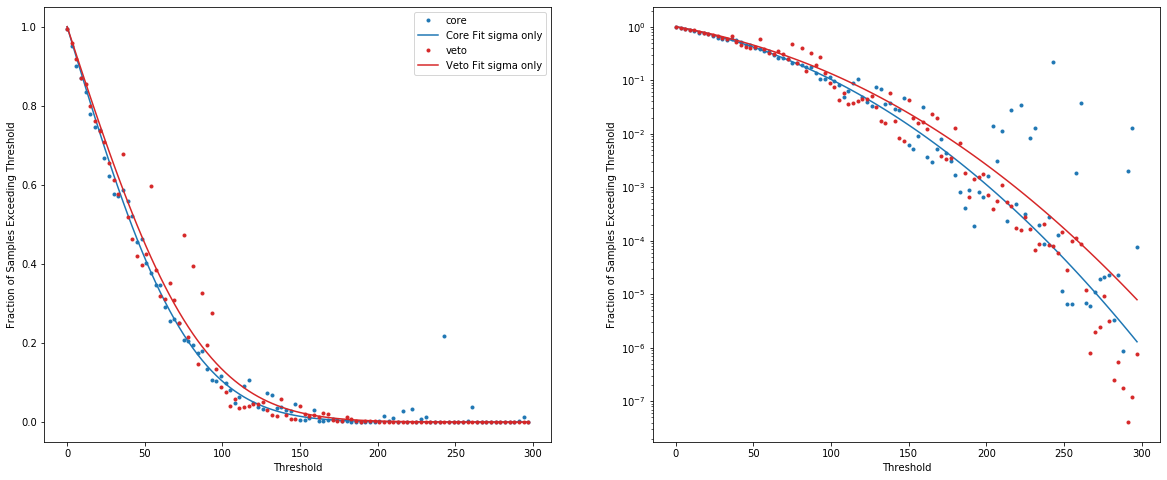

47
Fit Core
[1.40651696]
[[0.00034461]]
Fit Veto
[1.41636075]
[[0.00034108]]


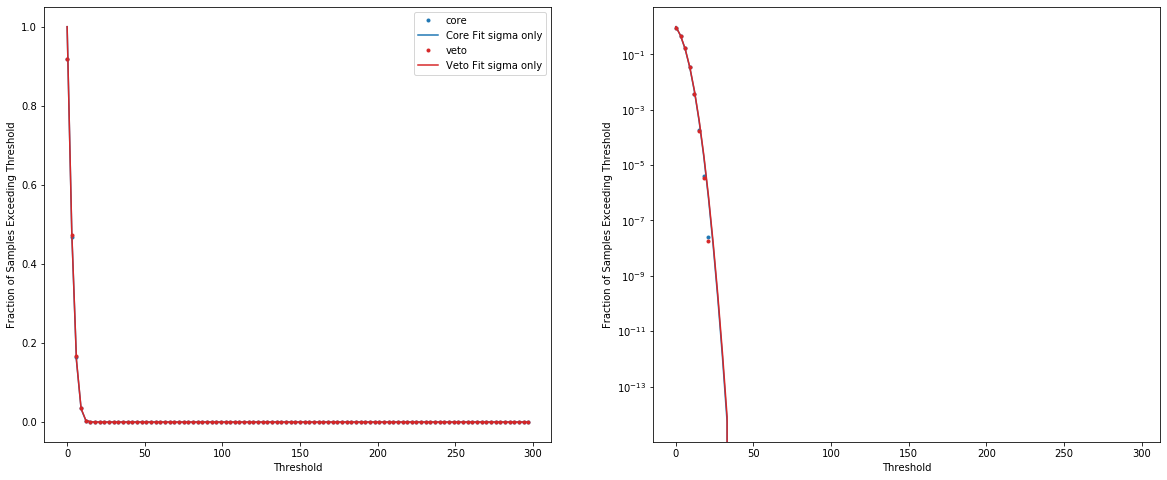

48
Fit Core
[19.00339881]
[[0.04674071]]
Fit Veto
[20.88923774]
[[0.16155588]]


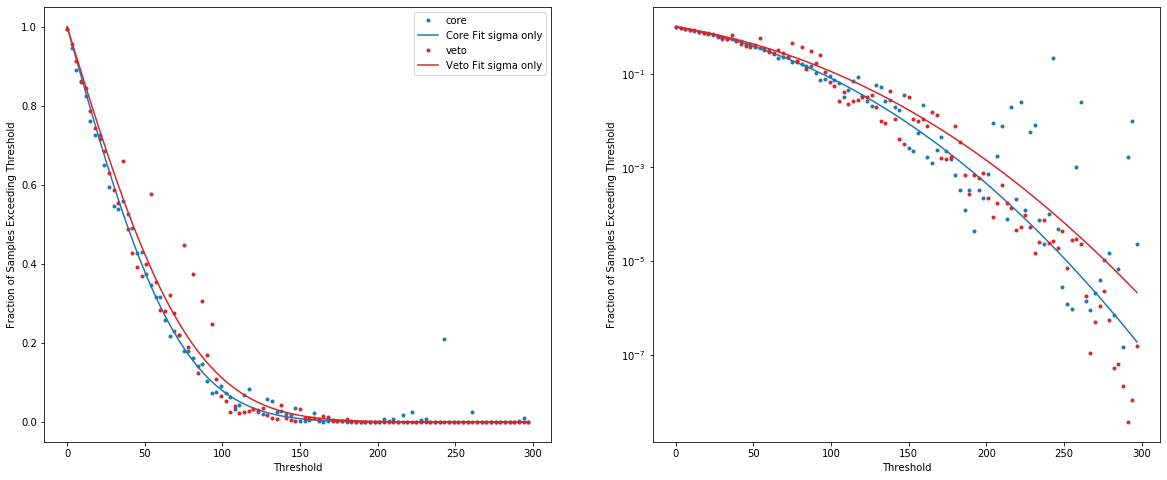

49
Fit Core
[19.55087585]
[[0.03062471]]
Fit Veto
[21.23676023]
[[0.08368023]]


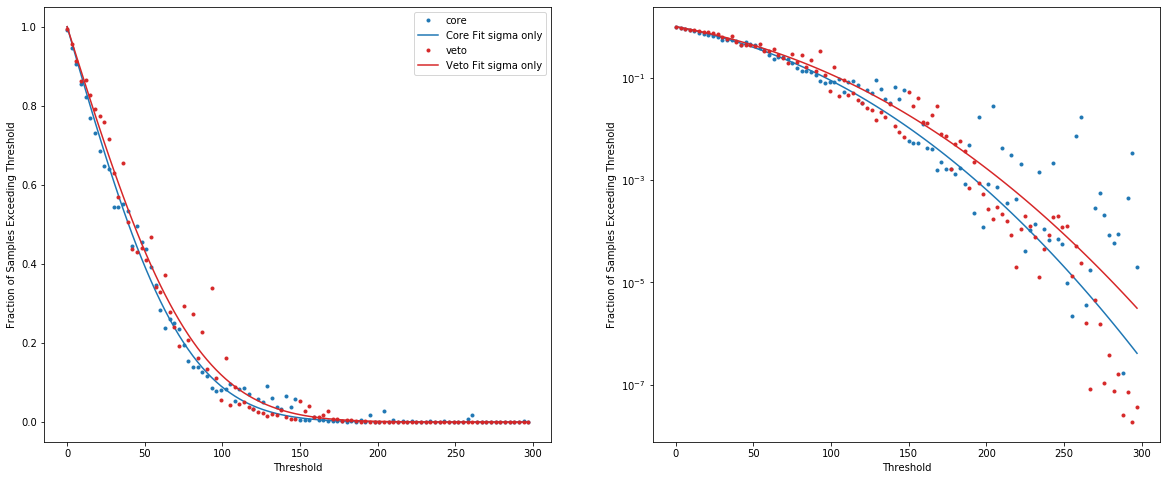

50
Fit Core
[1.72249084]
[[0.00039327]]
Fit Veto
[1.92566365]
[[0.0002288]]


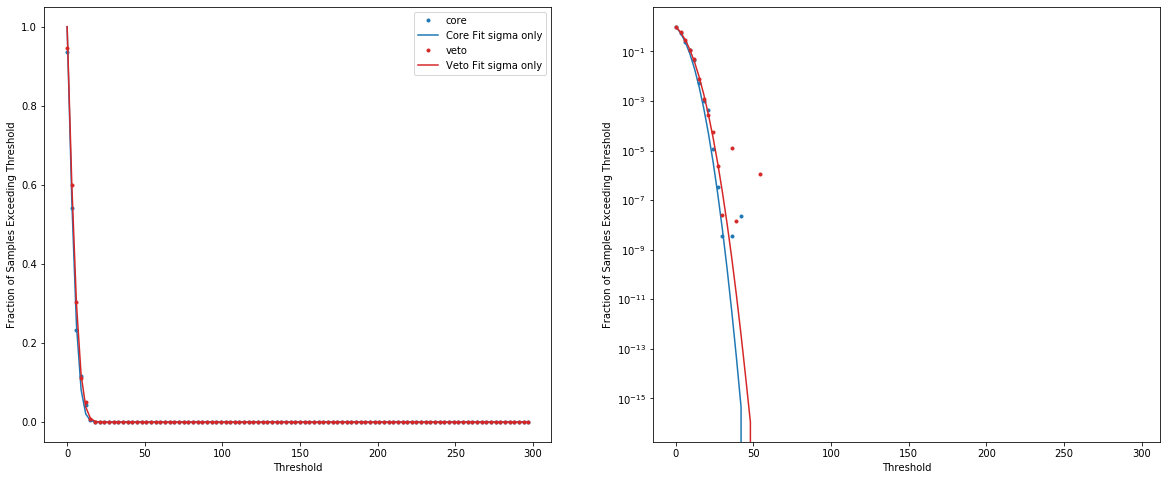

51
Fit Core
[16.51050498]
[[0.01569429]]
Fit Veto
[17.46380531]
[[0.03578024]]


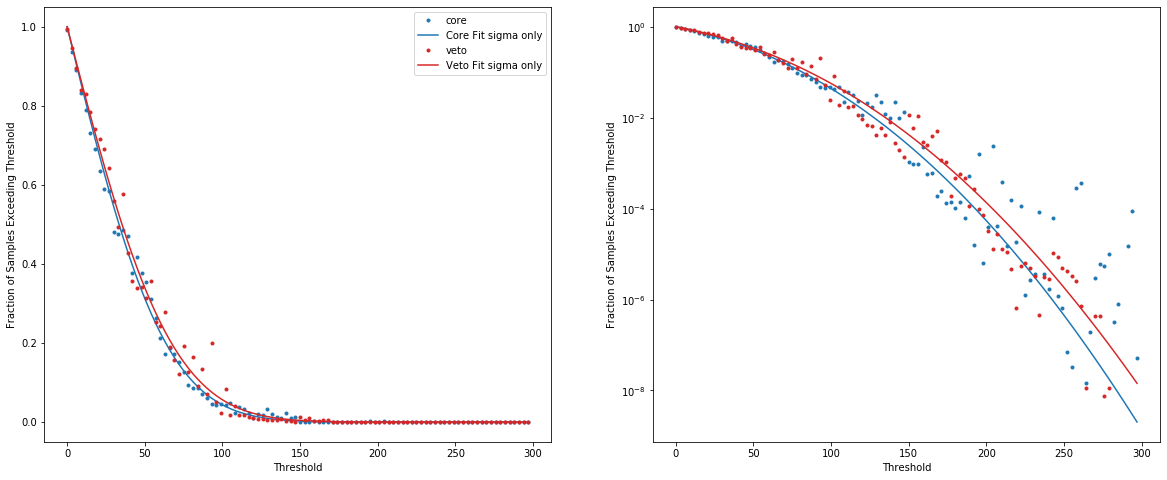

52
Fit Core
[18.73272325]
[[0.03960027]]
Fit Veto
[20.83898383]
[[0.13559064]]


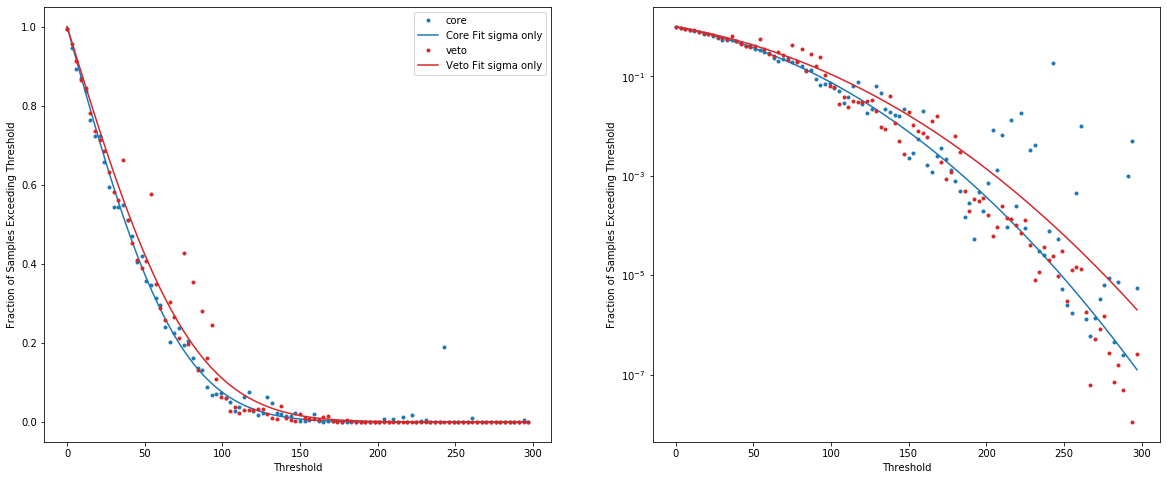

53
Fit Core
[18.73589599]
[[0.01770484]]
Fit Veto
[19.84588078]
[[0.05534515]]


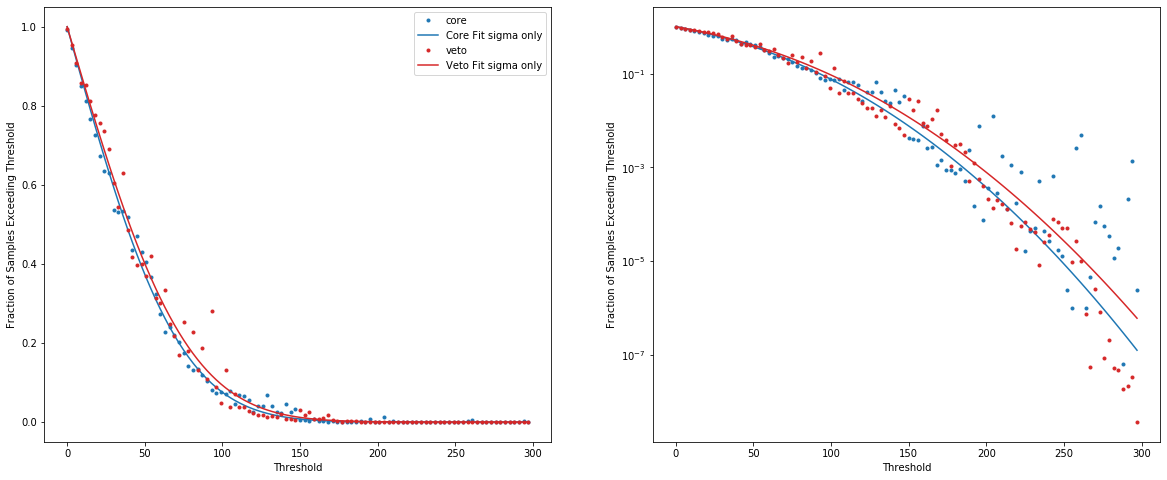

54
Fit Core
[19.07289585]
[[0.04213363]]
Fit Veto
[20.88975942]
[[0.14506565]]


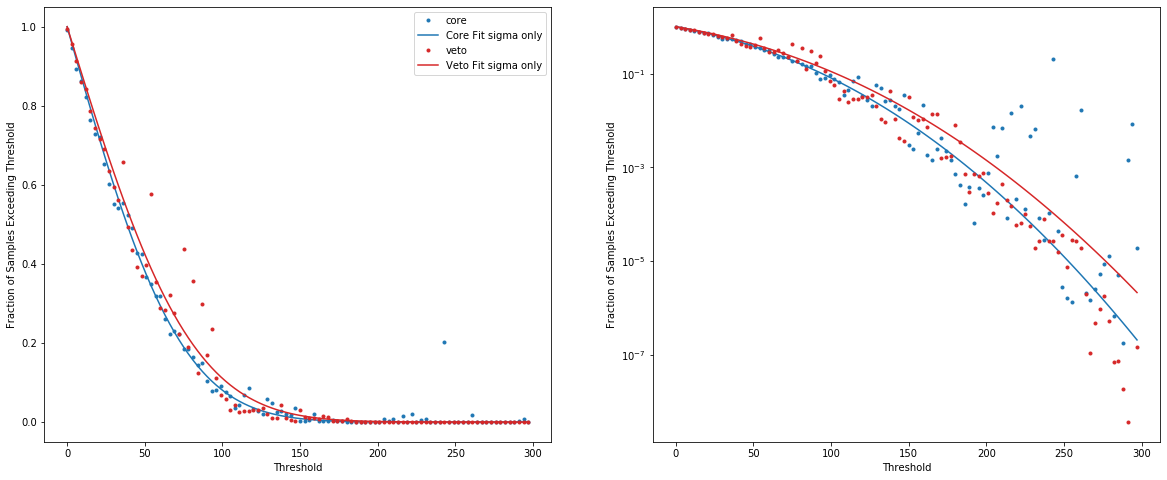

55
Fit Core
[20.09036169]
[[0.0223763]]
Fit Veto
[21.42341469]
[[0.06376686]]


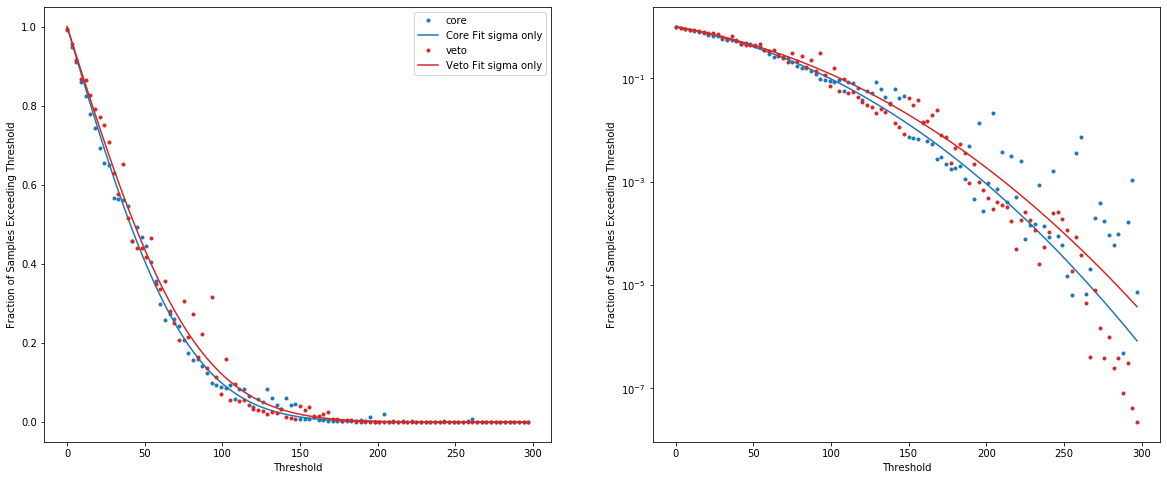

56
Fit Core
[48.765014]
[[0.642598]]
Fit Veto
[47.64905763]
[[0.29940659]]


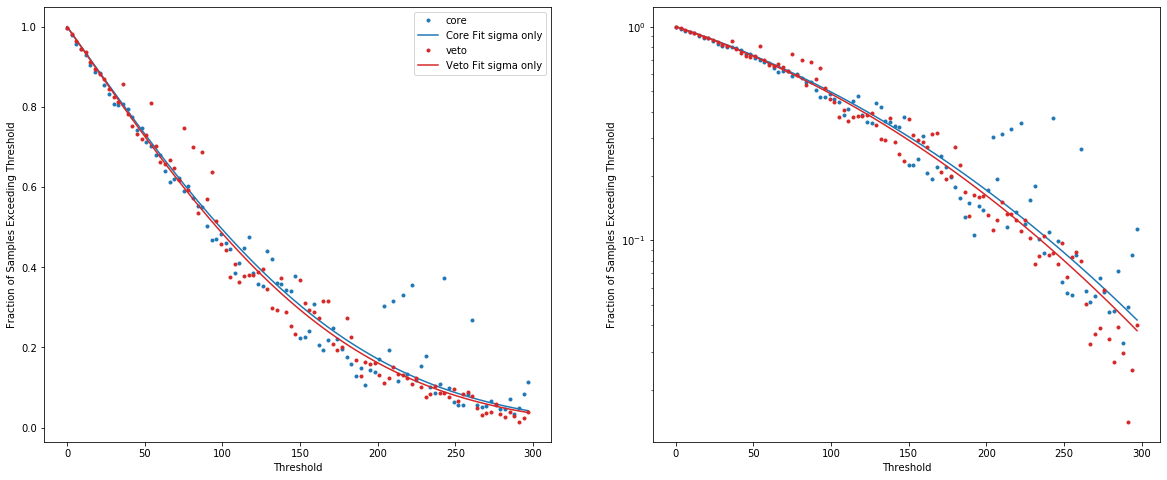

57
Fit Core
[18.07090933]
[[0.02000258]]
Fit Veto
[20.42868276]
[[0.04044311]]


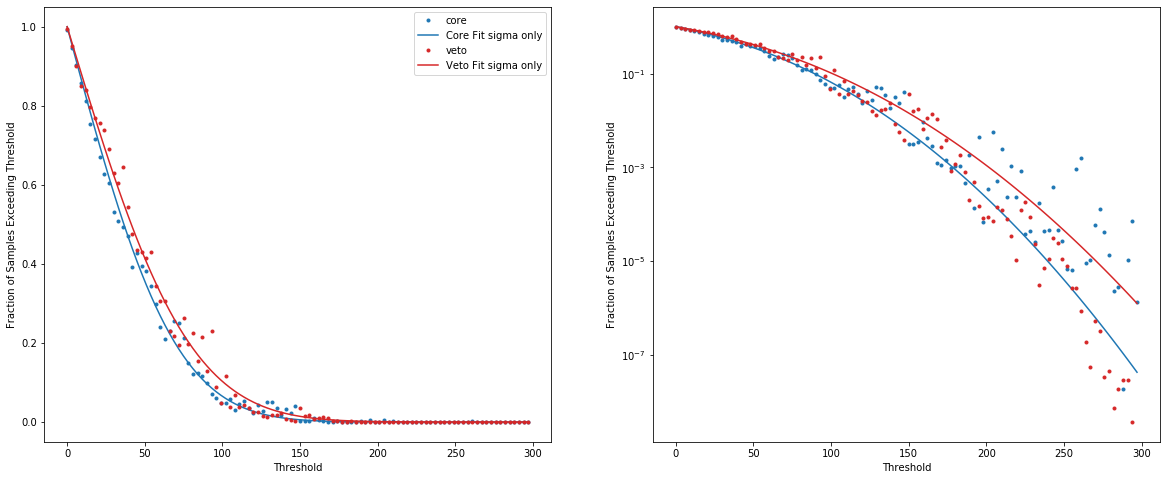

58
Fit Core
[20.1261618]
[[0.05699231]]
Fit Veto
[22.13598777]
[[0.16953113]]


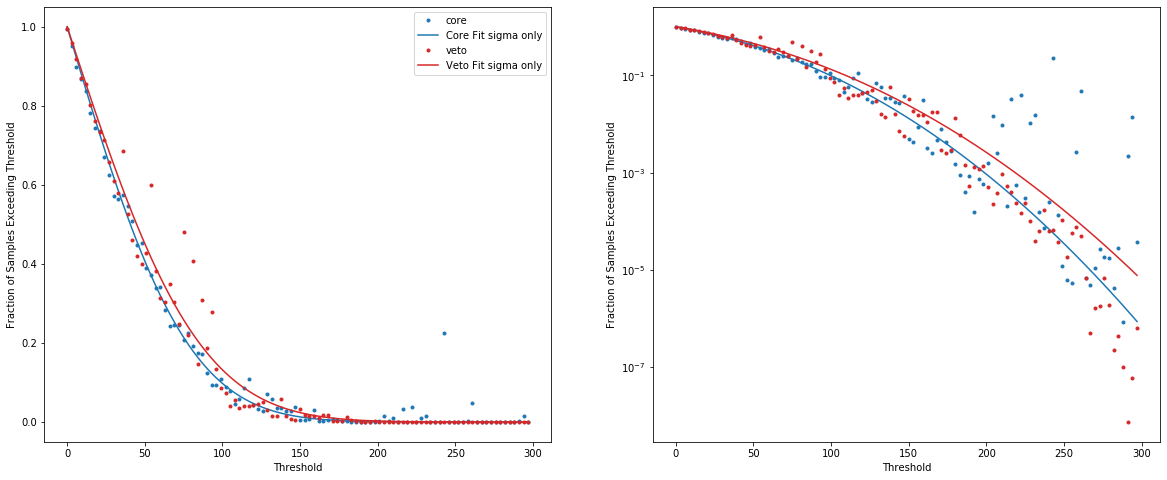

59
Fit Core
[18.18957273]
[[0.01585181]]
Fit Veto
[19.43188155]
[[0.05217247]]


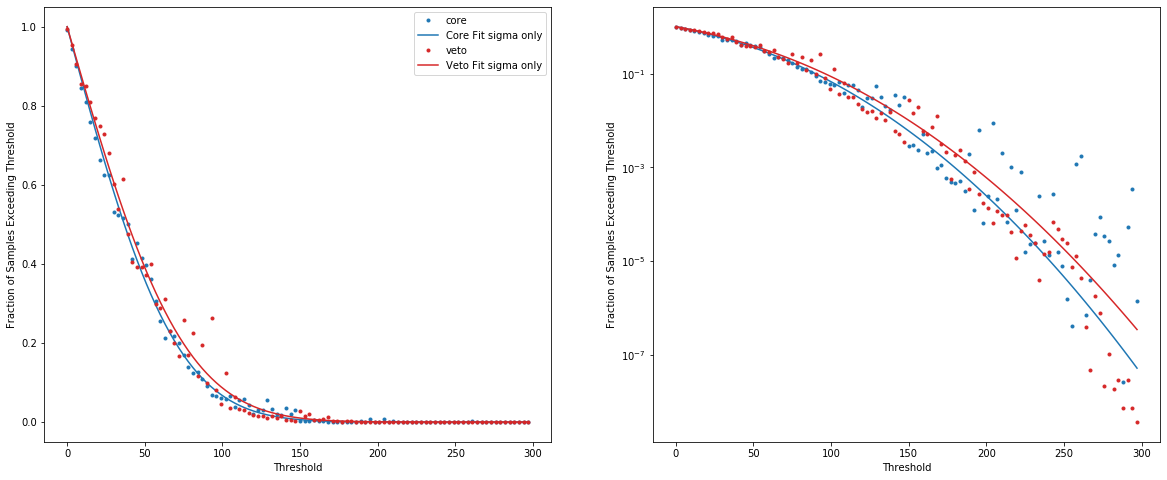

60
Fit Core
[19.14524448]
[[0.043]]
Fit Veto
[21.19473579]
[[0.1475491]]


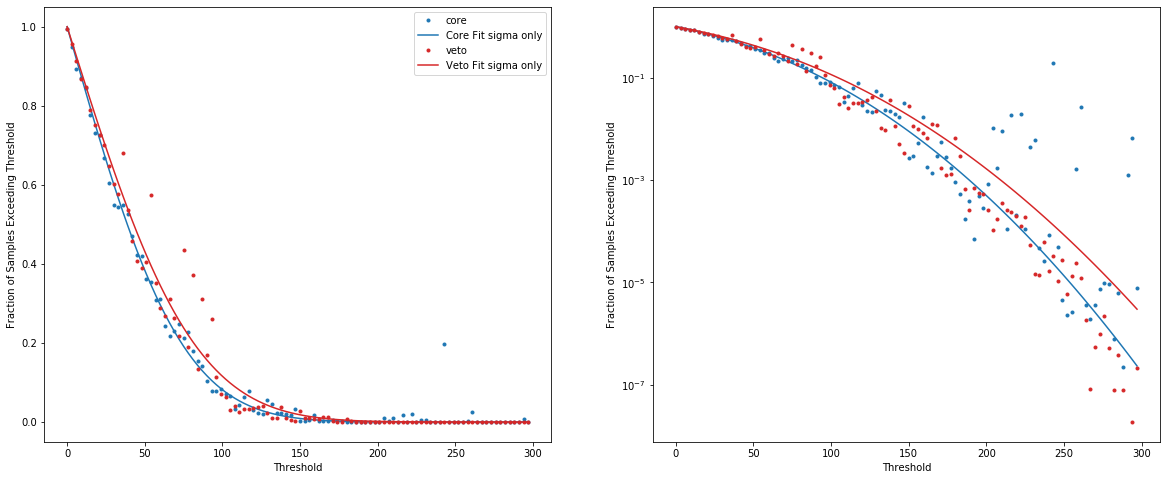

61
Fit Core
[16.54800206]
[[0.01223142]]
Fit Veto
[17.70987201]
[[0.02801904]]


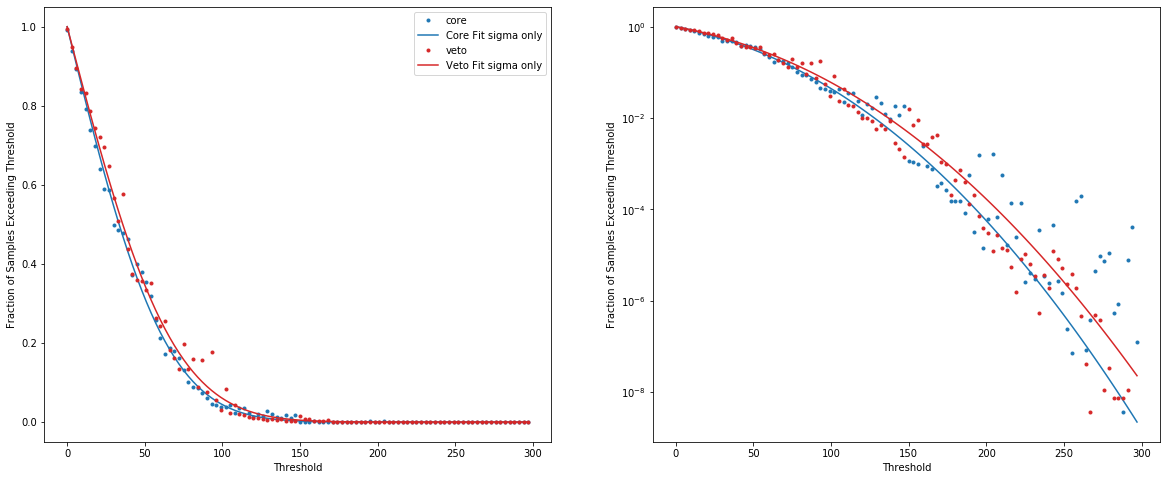

62
Fit Core
[19.28064752]
[[0.04517195]]
Fit Veto
[21.50592136]
[[0.15309458]]


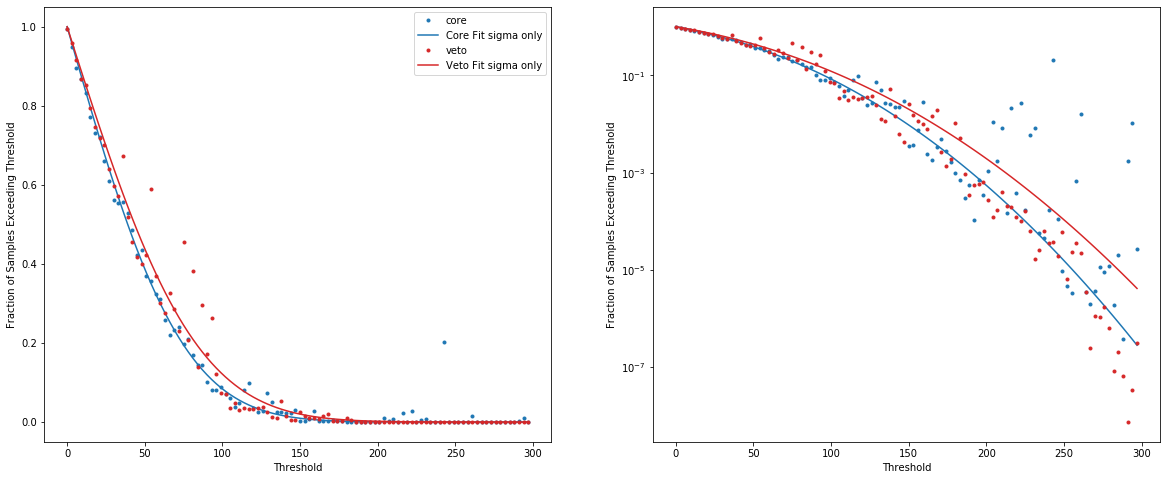

63
Fit Core
[16.77234697]
[[0.012144]]
Fit Veto
[18.07815422]
[[0.01553278]]


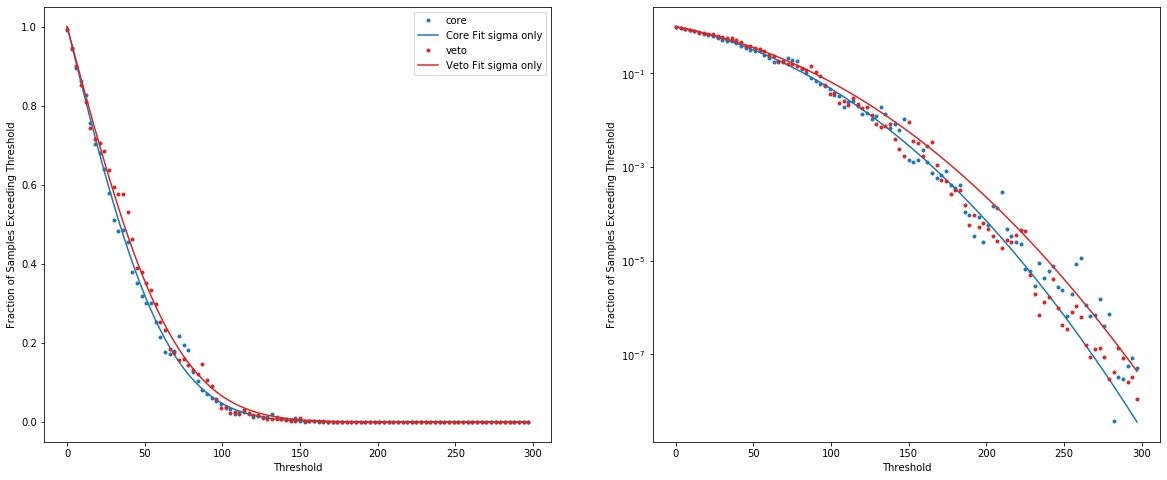

In [152]:
rate_core = savedresults_core/(2**28 - 1)
rate_veto = savedresults_veto/(2**28 - 1)

corefitsigmas = np.zeros(64)
corefitsigmaerrs = np.zeros(64)
vetofitsigmas = np.zeros(64)
vetofitsigmaerrs = np.zeros(64)

for a in range(64):
    print(a)
    print("Fit Core")
    popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:])
    corefitsigmas[a]=popt1[0]
    corefitsigmaerrs[a]=pcov1[0]
    print(popt1)
    print(pcov1)

    print("Fit Veto")
    popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[a,:]))
    vetofitsigmas[a]=popt2[0]
    vetofitsigmaerrs[a]=pcov2[0]
    print(popt2)
    print(pcov2)

    model1 = prob_simple(thresholds,popt1[0])
    model2 = prob_simple(thresholds,popt2[0])

    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.plot(savedthresholds,rate_core[a,:],'C0.',label='core')
    plt.plot(savedthresholds,model1,'C0-',label="Core Fit sigma only")

    plt.plot(np.flip(savedthresholds),rate_veto[a,:],'C3.',label='veto')
    plt.plot(savedthresholds,model2,'C3-',label="Veto Fit sigma only")

    plt.legend()

    plt.subplot(122)
    plt.xlabel("Threshold")
    plt.ylabel("Fraction of Samples Exceeding Threshold")
    plt.semilogy(savedthresholds,rate_core[a,:],'C0.',label='core')
    plt.semilogy(savedthresholds,model1,'C0-',label="Core Fit sigma only")

    plt.semilogy(np.flip(savedthresholds),rate_veto[a,:],'C3.',label='veto')
    plt.semilogy(savedthresholds,model2,'C3-',label="Veto Fit sigma only")
    plt.show()

Now there is low power on input 50, which is 241A, the other polarization of the antenna that had power drops before.

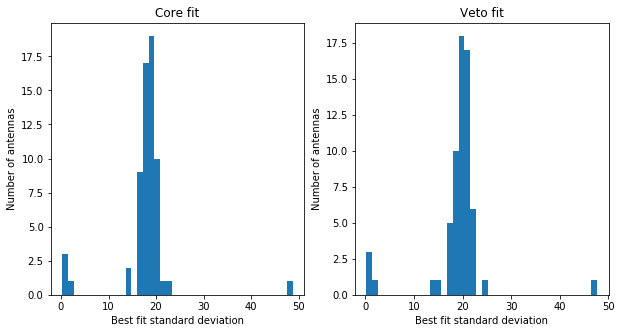

In [165]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Core fit")
plt.hist(corefitsigmas,40)
plt.xlabel("Best fit standard deviation")
plt.ylabel("Number of antennas")

plt.subplot(122)
plt.title("Veto fit")
plt.hist(vetofitsigmas,40)
plt.xlabel("Best fit standard deviation")
plt.ylabel("Number of antennas")
plt.show()

In [174]:
#Put all on one plot for comparison 
colors = ["#934b71",
    "#48c152",
    "#9a44bc",
    "#78c341",
    "#4a62d8",
    "#abc136",
    "#a076e9",
    "#6b9c29",
    "#dd70db",
    "#389139",
    "#c63695",
    "#39c685",
    "#d93668",
    "#81be6d",
    "#7854b1",
    "#d0b737",
    "#578cea",
    "#e7a332",
    "#5d63b4",
    "#e58323",
    "#3a69af",
    "#dd6128",
    "#54b9e5",
    "#be2e2c",
    "#46c6c4",
    "#ea5749",
    "#329981",
    "#ea6098",
    "#428f5c",
    "#a24e99",
    "#a6a83d",
    "#c58fdb",
    "#767c16",
    "#e381be",
    "#587b28",
    "#9c9cde",
    "#987516",
    "#5092c9",
    "#bd7426",
    "#5a5f94",
    "#c69d3f",
    "#88609d",
    "#357137",
    "#b14a78",
    "#6ebf92",
    "#a4384a",
    "#277257",
    "#d56470",
    "#78964f",
    "#e08ea5",
    "#586113",
    "#e88c79",
    "#56642b",
    "#cd6a49",
    "#b7b771",
    "#96515d",
    "#908645",
    "#a04616",
    "#dda573",
    "#a45141",
    "#755a1c",
    "#ec945a",
    "#89562c",
    "#ad7947"]

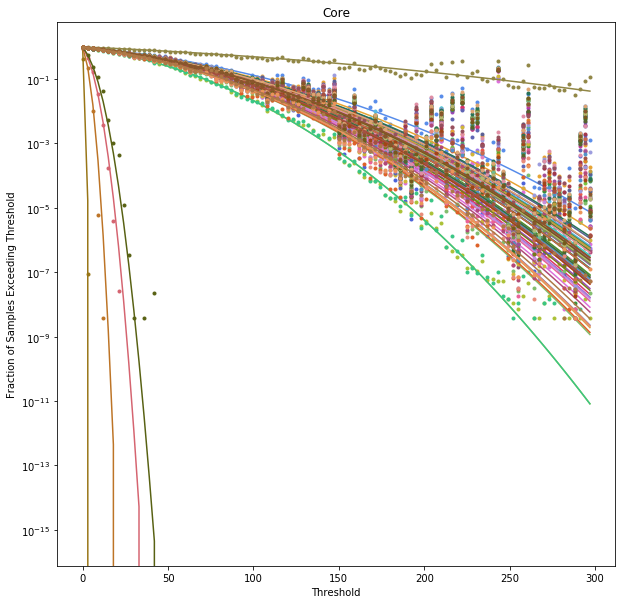

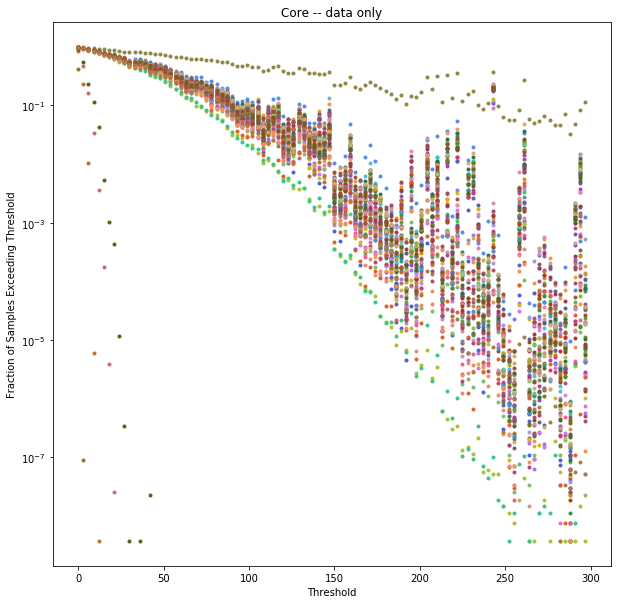

In [178]:


plt.figure(figsize=(10,10))
plt.title("Core")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])
    #model2 = prob_simple(thresholds,vetofitsigmas[a])
    plt.semilogy(savedthresholds,model1,color=colors[a],label="Core Fit sigma only")
    plt.semilogy(savedthresholds,rate_core[a,:],'.',color=colors[a],label=str(a))

    #plt.semilogy(np.flip(savedthresholds),rate_veto[a,:],'C3.',label='veto')
    #plt.semilogy(savedthresholds,model2,'C3-',label="Veto Fit sigma only")

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
#plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.title("Core -- data only")
for a in range(64):
    model1 = prob_simple(thresholds,corefitsigmas[a])
    #model2 = prob_simple(thresholds,vetofitsigmas[a])
    #plt.semilogy(savedthresholds,model1,color=colors[a],label="Core Fit sigma only")
    plt.semilogy(savedthresholds,rate_core[a,:],'.',color=colors[a],label=str(a))

    #plt.semilogy(np.flip(savedthresholds),rate_veto[a,:],'C3.',label='veto')
    #plt.semilogy(savedthresholds,model2,'C3-',label="Veto Fit sigma only")

plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
#plt.legend()
plt.show()



Should I go to higher values?  A big concern is the time it takes to do these scans-- much longer than the time over which environment is stable.

# 3. FEE Off Whitenoise

In [181]:
print(2**28/1e8)

2.68435456
